# Analyses codes for Han et al., 2022

This Jupyter Notebook was used to analyse and create figures for _Estimating the potential need and impact of SARS-CoV-2 test-and-treat programs with oral antivirals in low-and-middle-income countries_ (Han et al. 2022).

## Import libraries

In [1]:
import os
import re 
import pandas as pd
import numpy as np
import ast
import string

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns 

if not os.path.isdir("./figures"): 
    os.mkdir("./figures")
    
if not os.path.isdir('./results'): 
    os.mkdir('./results')

## Estimating testing rates in the Netherlands 

We used open data from the Dutch National Institute for Public Health and the Environment (RIVM) to estimate differences in testing rates reported by municipal health services between the period up to the spread of Omicron BA.1 wave and after the Omicron BA.1 wave (when testing instrastructure were substantially downscaled). 

In [2]:
def get_daily_test_average(start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)    
    fdf = rivm_test_data[(rivm_test_data['Date_of_statistics']>=start_date)&(rivm_test_data['Date_of_statistics']<=end_date)]
    test_rate = np.zeros(len(fdf['Date_of_statistics'].unique()))
    for d, date in enumerate(fdf['Date_of_statistics'].unique()): 
        date_fdf = fdf[fdf['Date_of_statistics']==date]
        test_rate[d] = (date_fdf['Tested_with_result']/date_fdf['pop_n']*1e5).mean()
    return test_rate.mean()

nl_pop_data = pd.read_csv("./data/NL_pop_data.csv").set_index("Veiligheidsregiocode")

rivm_test_data = pd.read_csv("./data/COVID-19_testing_data_from_RIVM.csv", sep=';')
rivm_test_data['Date_of_statistics'] = pd.to_datetime(rivm_test_data['Date_of_statistics'])
rivm_test_data = rivm_test_data.dropna()
rivm_test_data['pop_n'] = rivm_test_data['Security_region_code'].map(nl_pop_data['Bevolkingsaantal'])

# get 21/Q1-22 daily testing average 
ba1_nl_test_rate = get_daily_test_average(start_date="2021-01-01", end_date='2022-03-31')
q2_22_nl_test_rate = get_daily_test_average(start_date="2022-04-01", end_date='2022-06-30')
print ('Mean testing rate in NL (2021 - Q1/2022) = ', ba1_nl_test_rate)
print ('Mean testing rate in NL (Q2/2022) = ', q2_22_nl_test_rate) 

Mean testing rate in NL (2021 - Q1/2022) =  7551.743032789028
Mean testing rate in NL (Q2/2022) =  640.8287955417419


## Country demographics 

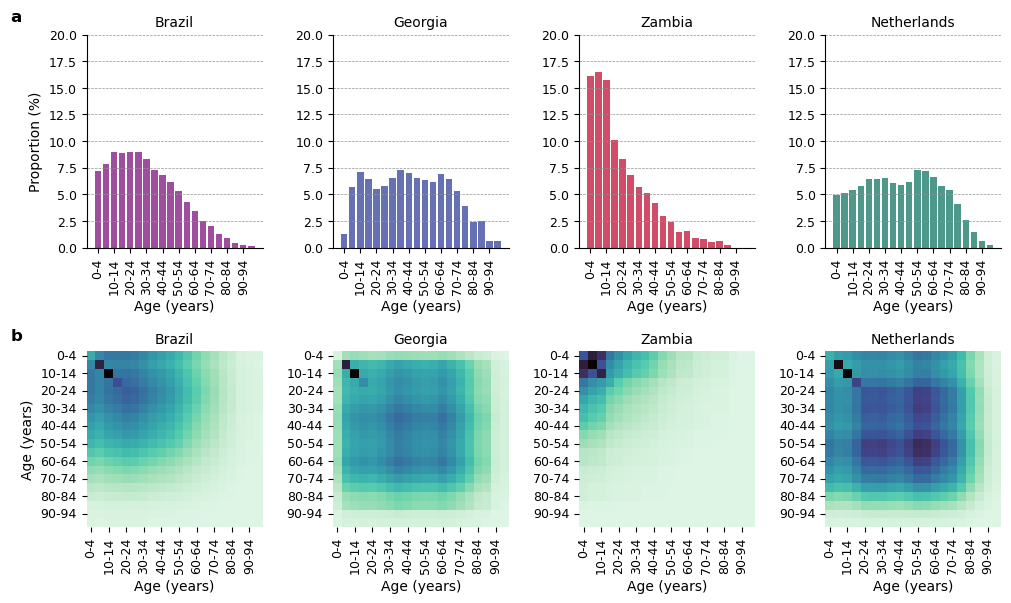

In [3]:
country_list = ['brazil', 'georgia', 'zambia', 'netherlands']
country_cols = {"brazil":['#f768a1','#c51b8a','#7a0177'], 
                "georgia":['#41b6c4','#2c7fb8','#253494'], 
                "zambia":['#fd8d3c','#f03b20','#bd0026'], 
                "netherlands":['#67a9cf','#1c9099','#016c59']}

country_to_age_struc = {}
with plt.style.context("default"): 
    fig = plt.figure(figsize=(11.8, 8.3*0.8))
    gs = GridSpec(nrows=2, ncols=4, wspace=0.4, hspace=0.4)
    # plot age distribution 
    for c, country in enumerate(country_list): 
        ax = fig.add_subplot(gs[0,c])
        df = pd.read_excel("./data/patat_input_file_%s.xlsx"%(country)).set_index("parameter")
        height = np.array(ast.literal_eval(df.loc['age_structure', 'value']))*100
        country_to_age_struc[country] = height
        ax.bar(x=np.arange(len(height)), height=height, color=country_cols[country][-1], alpha=0.7)
        ax.set_ylim(0., 20)
        ax.set_xticks(np.arange(0, len(height), 2))
        ax.set_xticklabels(["%i-%i"%(i, i+4) for i in np.arange(0, 100, 5)][::2], rotation=90)
        if c == 0: 
            ax.set_ylabel("Proportion (%)", fontsize=10)
        ax.set_title(country.capitalize(), fontsize=10)
        for axis in ['top', 'right']: 
            ax.spines[axis].set_visible(False)
        ax.grid(axis='y', lw=0.5, ls='--', c='#929292')
        ax.tick_params(axis='both', labelsize=9)
        ax.set_xlabel('Age (years)', fontsize=10)
        
        # plot contact matrices 
        ax = fig.add_subplot(gs[1,c])
        contact_mat = np.load("./data/contact_mat_%s.npz"%(country))['contact_mat']
        sns.heatmap(contact_mat, cmap='mako_r', square=True, cbar=False, ax=ax)
        ax.set_xticks(np.arange(0, len(height), 2)+0.5)
        ax.set_xticklabels(["%i-%i"%(i, i+4) for i in np.arange(0, 100, 5)][::2], rotation=90)
        ax.set_yticks(np.arange(0, len(height), 2)+0.5)
        ax.set_yticklabels(["%i-%i"%(i, i+4) for i in np.arange(0, 100, 5)][::2], rotation=0)
        ax.set_title(country.capitalize(), fontsize=10)
        if c == 0: 
            ax.set_ylabel('Age (years)', fontsize=10)
        ax.set_xlabel('Age (years)', fontsize=10)
        ax.tick_params(axis='both', labelsize=9)
        
    fig.text(x=0.06, y=0.9, s=r"$\bf{a}$", fontsize=12, transform=fig.transFigure)
    fig.text(x=0.06, y=0.42, s=r"$\bf{b}$", fontsize=12, transform=fig.transFigure)
    plt.savefig('./figures/FigureS1.png', dpi=600, bbox_inches='tight')
    plt.show()

## Compute summary statistics of simulation outputs

In [4]:
feature_labels = ['baseline', 'Rt', 'ntest', 'test_prob', 'vacc_prob', 'vacc_eff', 'risk_prev', 'symp_restrict', 'test_asymp']
train_feature_range = {'baseline': [0, 1], 'Rt': [0.9, 1.2, 1.5, 2.0], 
                       'ntest': [10, 100, 500], 'test_prob': [0.5, 0.65], 
                       'vacc_prob': [0.1, 0.5, 0.9], 'vacc_eff': [0, 1], 
                       'risk_prev': [0.1, 0.2], 'symp_restrict': [0, 1], 
                       'test_asymp': [0, 1]}

num_vars = ['mean_inf_days_pax'] + ["n_transmission_%s"%(dissev) for dissev in ['asymp', 'presymp', 'mild', 'severe']] + ['infected_n', 'deaths_n', 'severe_n'] + ['av_disbured_rate']
sev_prob_vars = ['inf_%s_cond_prob_sev'%(risk_group) for risk_group in ['unvacc', 'risk', 'old']] 
dea_prob_vars = ['inf_%s_cond_prob_dead'%(risk_group) for risk_group in ['unvacc', 'risk', 'old']]
inf_age_vars = ['inf_age_%i'%(age) for age in np.arange(100)]
trans_sev_risk_vars = ['trans_from_HR_n', 'trans_from_LR_n', 'sev_cases_HR_n', 'sev_cases_LR_n']
onset_vars = ['d%i_onset_abv65_n'%(day) for day in np.arange(91)] + ['d%i_onset_tot_n'%(day) for day in np.arange(91)]
days_late_vars = ['reflex_test_delay_%i'%(add_day) for add_day in np.arange(8)]
treatini_vars = ['d%i_HR_initiated_av'%(day) for day in np.arange(91)] + ['d%i_HR_w_mild'%(day) for day in np.arange(91)]
# first four output vars are x > 0 and everything else 0 < x < 1 (probability)
output_vars = num_vars + sev_prob_vars + dea_prob_vars + inf_age_vars + trans_sev_risk_vars + onset_vars
output_names = [r"$n_{inf}$", r"$n_{dea}$", r"$n_{sev}$", r"$r_{antiviral}$", 
                r"$p_{sev|unvacc}$", r"$p_{sev|risk}$", r"$p_{sev|age}$", 
                r"$p_{dea|unvacc}$", r"$p_{dea|risk}$", r"$p_{dea|age}$"]

In [5]:
for country in country_list: 

    data_df = pd.read_csv("./data/simdata_%s.csv"%(country))
    # compute mean statistic for output variables 
    try: 
        summary_data_df = pd.read_csv("./data/summary_%s.csv"%(country))
    except:
        data_df = data_df.set_index(feature_labels).sort_index()
        # get summary data file 
        summary_data_df = []
        for idx in data_df.index.unique():
            fdf = (data_df.loc[idx].copy())
            row = {i:idx[_i] for _i, i in enumerate(feature_labels)}
            for var in list(fdf):
                row[var] = fdf[var].mean()
                row[var+"_sd"] = fdf[var].std(ddof=1)
            summary_data_df.append(row)
        summary_data_df = pd.DataFrame.from_dict(summary_data_df)
        summary_data_df.to_csv("./data/summary_%s.csv"%(country), index=False)
        
    #display (summary_data_df.head())

## Infections averted

In [6]:
ntest_linestyles = ['-.', '--', '-']
Rt_arr = np.array([0.9, 1.2, 1.5, 2.0])

def get_averted_plots(var, ylabel, ylabel2, ymin, ymax, ymin2, ymax2, ysep, symp_restrict=0, test_asymp=0, test_prob = 0.65, vacc_eff = 0, risk_prev = 0.2, fname=None, print_table=False): 
    print (var, "VE", vacc_eff, "TestProb", test_prob, "Risk", risk_prev, "SympRes", symp_restrict, "TestAsymp", test_asymp)
    
    fig = plt.figure(figsize=(8.3, 11.8 * 0.8))
    gs = GridSpec(nrows=3, ncols=3, wspace=0., hspace=0.6)

    print_df = []
    result_dict = {}
    for i, vacc_prob in enumerate([0.1, 0.5, .9]): 
        for j, country in enumerate(country_list[:3]): 
            ax = fig.add_subplot(gs[i,j])
            # read simdata 
            simdata = pd.read_csv("./data/simdata_%s.csv"%(country))
            # read summary data 
            summary_df = pd.read_csv("./data/summary_%s.csv"%(country))

            # filter data
            fdf = summary_df[(summary_df['vacc_prob']==vacc_prob)&(summary_df['vacc_eff']==vacc_eff)&(summary_df['test_prob']==test_prob)&(summary_df['risk_prev']==risk_prev)].copy()
            simdata_fdf = simdata[(simdata['vacc_prob']==vacc_prob)&(simdata['vacc_eff']==vacc_eff)&(simdata['test_prob']==test_prob)&(simdata['risk_prev']==risk_prev)].copy()
            
            base_df = fdf[(fdf['baseline']>0)].copy()
            base_df = base_df.set_index(['ntest', 'Rt']).sort_index()
            ana_df = fdf[(fdf['baseline']==0)&(fdf['test_asymp']==test_asymp)&(fdf['symp_restrict']==symp_restrict)].copy()
            curr_ana_df = ana_df.set_index(['ntest', 'Rt']).sort_index()
            
            base_simdata_df = simdata_fdf[(simdata_fdf['baseline']>0)].copy()
            base_simdata_df = base_simdata_df.set_index(['ntest', 'Rt']).sort_index()
            ana_simdata_df = simdata_fdf[(simdata_fdf['baseline']==0)&(simdata_fdf['test_asymp']==test_asymp)&(simdata_fdf['symp_restrict']==symp_restrict)].copy()
            curr_ana_simdata_df = ana_simdata_df.set_index(['ntest', 'Rt']).sort_index()

            y = curr_ana_df[var].to_numpy()
            y_sd = curr_ana_df[var+"_sd"].to_numpy()
            
            # compute averted ratio stats 
            y_base = base_df[var].to_numpy()
            y_base_sd = base_df[var+"_sd"].to_numpy()
            # compute covariance of y and y_base 
            cov_y_ybase = np.array([np.cov(base_simdata_df.loc[idx, var], curr_ana_simdata_df.loc[idx, var])[0,1] for idx in curr_ana_df.index])

            # compute mean and sd of numerator 
            num_sd = np.sqrt(y_base_sd**2 + y_sd**2 - 2*cov_y_ybase)
            num_mean = (y_base - y)
            
            plot_label = var+'_averted_n'
            curr_ana_df[plot_label] = num_mean
            curr_ana_df[plot_label+"_sd"] = num_sd
            
            num_mean[num_mean==0.] = 1e-6 
            # approximate sd of ratio 
            ratio_sd = num_mean**2/y_base**2 * (num_sd**2/num_mean**2 - (2 * cov_y_ybase/(num_mean*y_base)) + y_base_sd**2/y_base**2)
            ratio_sd = abs(ratio_sd)
            ratio_sd = 100*np.sqrt(ratio_sd)

            # compute averted y ratio
            y = 100*((y_base-y)/y_base)
            plot_label = var+'_averted_p'
            curr_ana_df[plot_label] = y
            curr_ana_df[plot_label+"_sd"] = ratio_sd
            
            try: 
                result_dict[vacc_prob][country] = curr_ana_df[[plot_label, plot_label+"_sd"]]
            except: 
                result_dict[vacc_prob] = {country:curr_ana_df[[plot_label, plot_label+"_sd"]]}
                
            if print_table: 
                print (vacc_prob, country)
                display (curr_ana_df[[plot_label]])
            
            # plot 
            ntest_list = sorted(curr_ana_df.index.get_level_values(0).unique())
            ntest_cols = country_cols[country]
            for k, ntest in enumerate(ntest_list):
                plot_x = np.array(sorted(curr_ana_df.index.get_level_values(1)))
                plot_y = curr_ana_df.loc[ntest].loc[plot_x, plot_label]
                plot_y_sd = curr_ana_df.loc[ntest].loc[plot_x, plot_label+"_sd"]
                
                print_df.append({'country':country, 'ntest':ntest, 
                                 'vacc_prob':vacc_prob, 'max_mu':"%.1f%%"%(max(plot_y))}) 
                
                #print (country, vacc_eff, vacc_prob, var, symp_restrict, )
                plot_x = np.searchsorted(Rt_arr, plot_x)
                ax.errorbar(np.array(plot_x)+(0.25*(k-1)), plot_y, yerr=plot_y_sd, c=ntest_cols[k], lw=1., ls=ntest_linestyles[k], zorder=100)
                ax.scatter(np.array(plot_x)+(0.25*(k-1)), plot_y, color=ntest_cols[k], s=30, marker=".", zorder=200)

            # cosmetics 
            ax.set_ylim(ymin, ymax)
            ax.set_yticks(np.linspace(ymin, ymax, ysep))
            yticklabels = ["%i%%"%(-y) if y >= 0 else "+%i%%"%(abs(y)) for y in np.linspace(ymin, ymax, ysep)]
            ax.set_yticklabels(yticklabels)
            ax.grid(axis='y', ls='--', lw=0.5, c='#929292', zorder=-100, alpha=0.5)
            ax.set_xticks(np.arange(4))
            ax.set_xticklabels(Rt_arr)
            if j > 0: 
                ax.set_yticklabels([])
                if j == 1: 
                    ax.set_xlabel(r"$R_t$", fontsize=10)
            else: 
                ax.set_ylabel(ylabel, fontsize=10)    
            for axis in ['top', 'right']:
                ax.spines[axis].set_visible(False)
            
            ax.set_title(country.capitalize(), fontsize=12)
            
            # plot actual number of cases averted 
            ax2 = ax.twinx()
            f = sns.barplot(x="Rt", y=var, hue="ntest", data=base_df.reset_index(), ax=ax2, 
                            zorder=0, facecolor=(1, 1, 1, 0), linewidth=1.5,
                            linestyle='dotted',
                            edgecolor=country_cols[country][-1], 
                            alpha=0.7)# capsize=.2)
            f.legend_.remove()
            
            plot_df = curr_ana_df.copy().reset_index()
            g = sns.barplot(x="Rt", y=var, hue="ntest", data=plot_df, ax=ax2, 
                            zorder=1, palette=country_cols[country], alpha=0.7)# capsize=.2)
            g.legend_.remove()
            ax2.set_ylim(ymin2, ymax2)
            ax2.set_yticks(np.linspace(ymin2, ymax2, ysep))
            
            for axis in ['top', 'left']:
                ax2.spines[axis].set_visible(False)
            if j < 2: 
                ax2.set_yticklabels([])
                ax2.set_ylabel("")
                ax2.tick_params(axis='both', left=False, right=False, top=False, bottom=False)
            else: 
                ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
                ax2.set_ylabel(ylabel2, rotation=270, va='top', ha='center', fontsize=10)
                ax2.yaxis.set_label_coords(1.32,0.5)
                
            ax.set_zorder(ax2.get_zorder()+1)
            ax.patch.set_visible(False)
            #ax.set_zorder(1)
            #ax2.set_zorder(0)
                
    # label 
    fig.text(x=0.04, y=0.93, s=r"$\bf{a)}$" + " Vaccination coverage = 10%", fontsize=12, transform=fig.transFigure)
    fig.text(x=0.04, y=0.635, s=r"$\bf{b)}$" + " Vaccination coverage = 50%", fontsize=12, transform=fig.transFigure)
    fig.text(x=0.04, y=0.335, s=r"$\bf{c)}$" + " Vaccination coverage = 90%", fontsize=12, transform=fig.transFigure)

    # legend 
    legend_elements = []
    for i, ntest in enumerate(ntest_list):
        legend_elements.append(Line2D([0], [0], marker='o', color=['#969696','#636363','#252525'][i], 
                                      label='%i tests/100,000 people/day'%(ntest),
                                      markerfacecolor=['#969696','#636363','#252525'][i], lw=1., ls=ntest_linestyles[i],
                                      markersize=5),)
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1., 0.5))
    if fname == None: 
        plt.savefig('./figures/LMIC_averted_%s_VaccEff%i_TestProb%.1f_Risk%.1f_SympRes%i_TestAsymp%i.png'%(var, vacc_eff, test_prob, risk_prev, symp_restrict, test_asymp), dpi=330, bbox_inches='tight')
    else: 
        plt.savefig('./figures/%s.png'%(fname), dpi=600, bbox_inches='tight')
    plt.show()
    
    #print_df = pd.DataFrame.from_dict(print_df).sort_values(by=['country', 'vacc_prob', 'ntest'])
    #display (print_df)
    
    return result_dict

infected_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 0


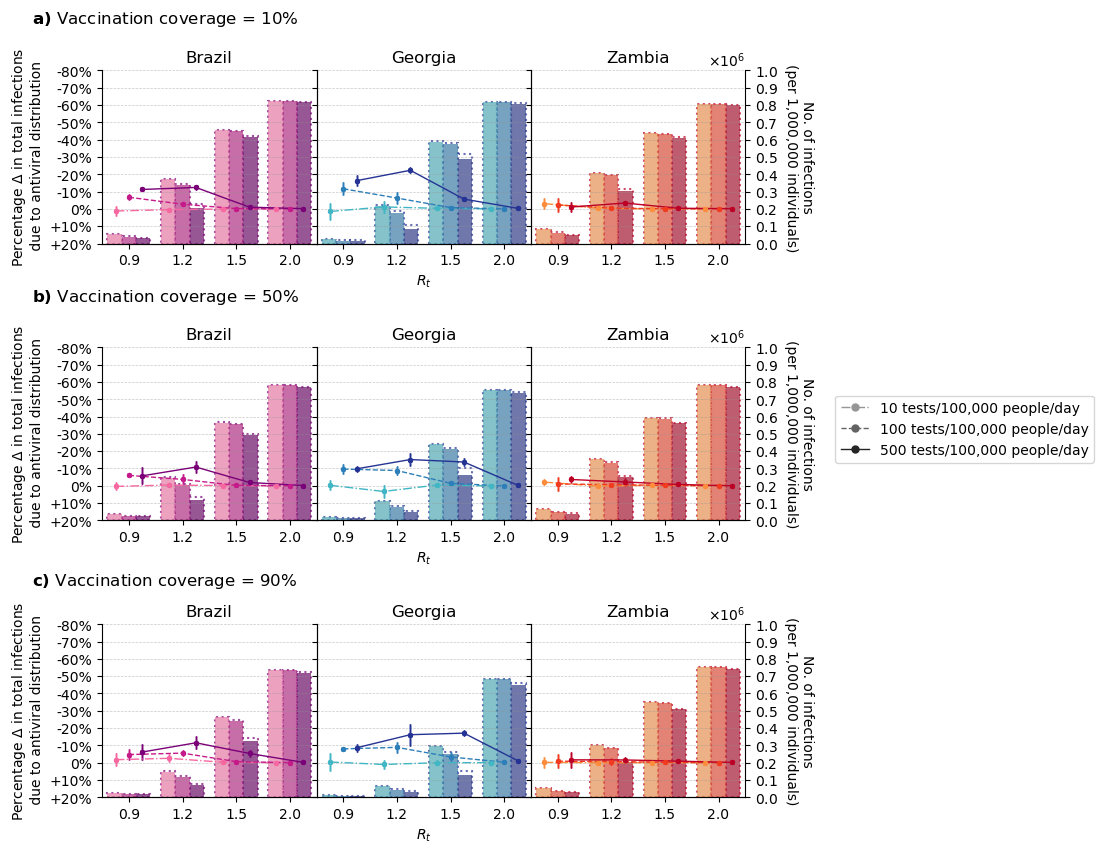

infected_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 1


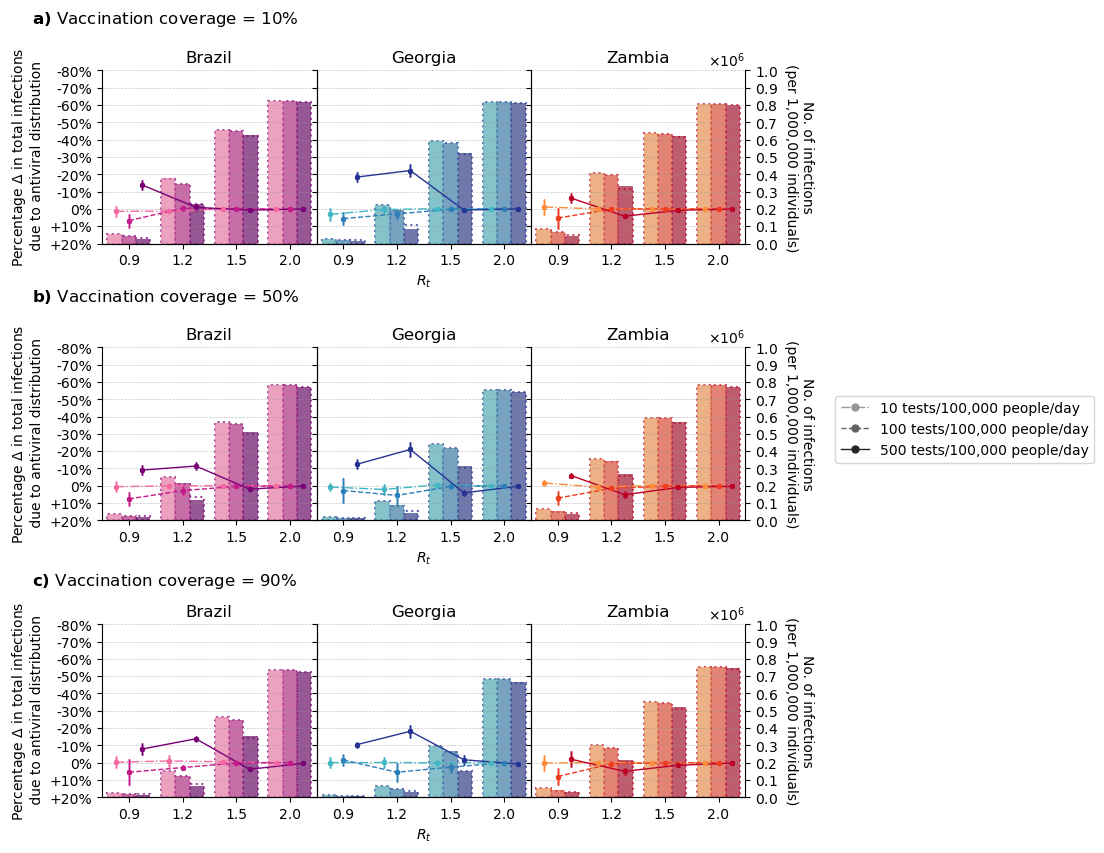

infected_n VE 0 TestProb 0.65 Risk 0.2 SympRes 1 TestAsymp 0


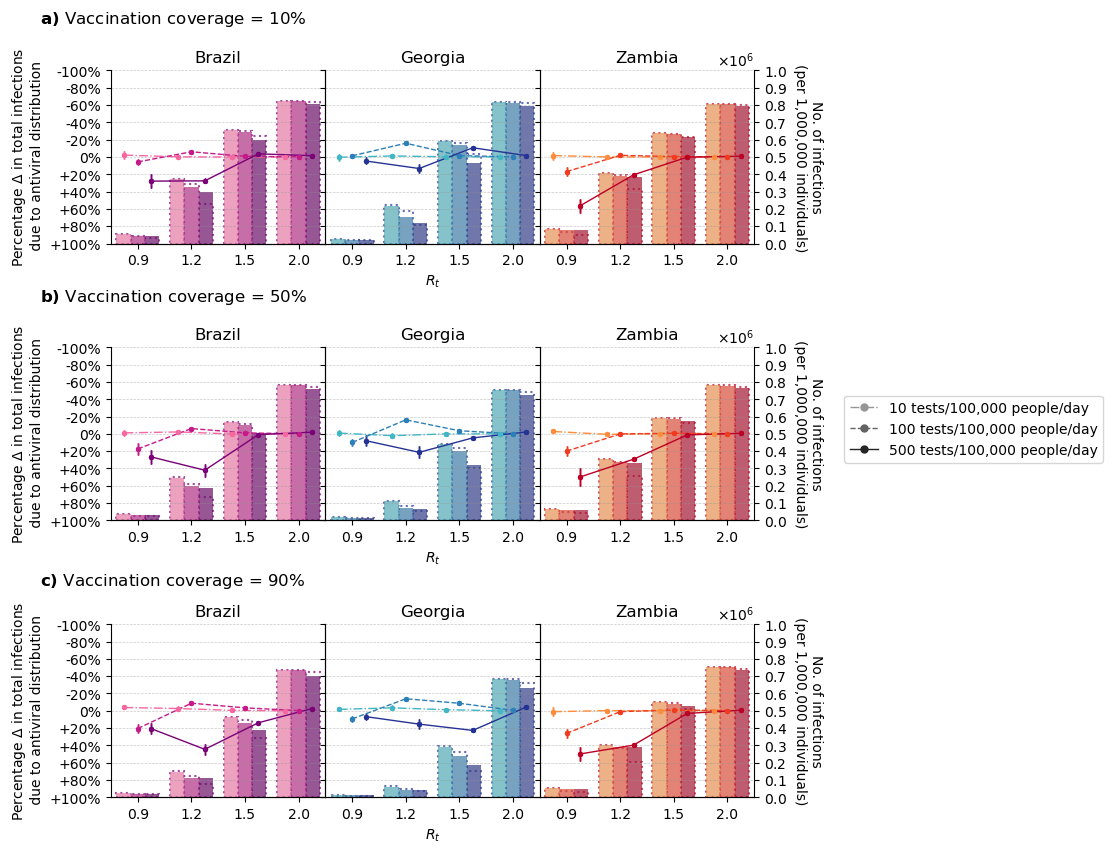

In [7]:
with plt.style.context("default"): 
    get_averted_plots(var = "infected_n", ylabel = "Percentage " + r"$\Delta$" + " in total infections\n due to antiviral distribution", 
                      ylabel2 = "No. of infections\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=80, ymin2=0., ymax2=10e5, ysep=11,
                      test_asymp=0, symp_restrict=0, fname='FigureS2')
    
    get_averted_plots(var = "infected_n", ylabel = "Percentage " + r"$\Delta$" + " in total infections\n due to antiviral distribution", 
                      ylabel2 = "No. of infections\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=80, ymin2=0., ymax2=10e5, ysep=11,
                      test_asymp=1, symp_restrict=0, fname='FigureS5')
    
    get_averted_plots(var = "infected_n", ylabel = "Percentage " + r"$\Delta$" + " in total infections\n due to antiviral distribution", 
                      ylabel2 = "No. of infections\n(per 1,000,000 individuals)",
                      ymin=-100, ymax=100, ymin2=0., ymax2=10e5, ysep=11,
                      test_asymp=0, symp_restrict=1, fname='FigureS8')# print_table=True)

/var/folders/tj/t8y9975d6_gd2b1hwc574cq80000gn/T/ipykernel_46577/2059518518.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fdf = simdata_df[["n_transmission_%s"%(dissev) for dissev in ['asymp', 'presymp', 'mild', 'severe']]]/sum_trans[:,None]
/var/folders/tj/t8y9975d6_gd2b1hwc574cq80000gn/T/ipykernel_46577/2059518518.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fdf = simdata_df[["n_transmission_%s"%(dissev) for dissev in ['asymp', 'presymp', 'mild', 'severe']]]/sum_trans[:,None]
/var/folders/tj/t8y9975d6_gd2b1hwc574cq80000gn/T/ipykernel_46577/2059518518.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to 

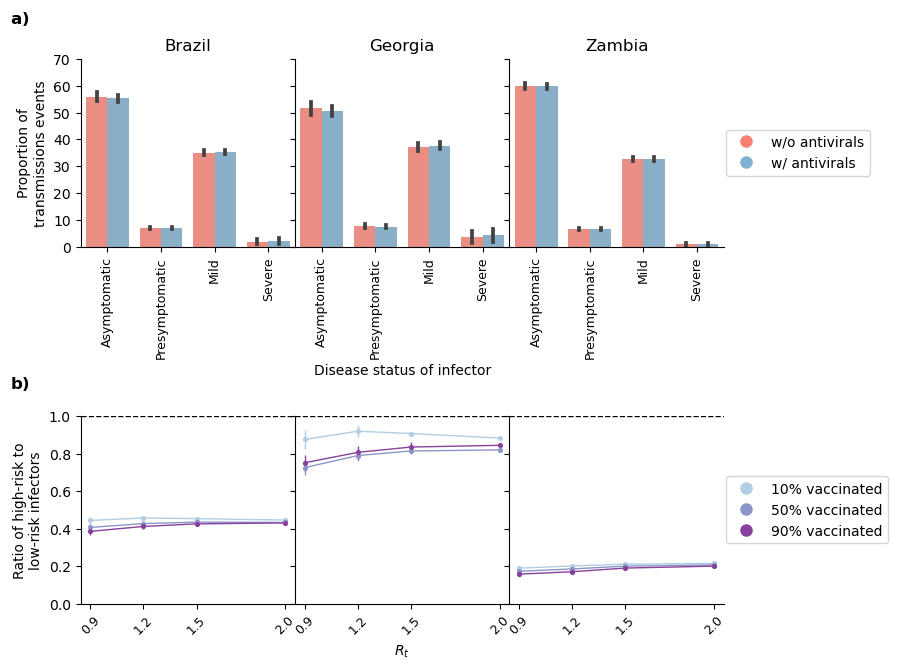

In [8]:
with plt.style.context('default'):
    fig = plt.figure(figsize=(8.3, 11.8 * 0.6))
    gs = GridSpec(nrows=2, ncols=3, wspace=0., hspace=0.9)
    
    ## breakdown of transmissions by disease severity ## 
    cmap = ["#fb8072", "#80b1d3"]
    for j, country in enumerate(country_list[:3]): 
        ax = fig.add_subplot(gs[(0,j)])
        # read summary data 
        simdata_df = pd.read_csv("./data/simdata_%s.csv"%(country))
        simdata_df = simdata_df[(simdata_df['test_prob']==.65)&(simdata_df['risk_prev']==.2)&(simdata_df['vacc_eff']==0)]
        sum_trans = simdata_df[["n_transmission_%s"%(dissev) for dissev in ['asymp', 'presymp', 'mild', 'severe']]].sum(axis=1)
        fdf = simdata_df[["n_transmission_%s"%(dissev) for dissev in ['asymp', 'presymp', 'mild', 'severe']]]/sum_trans[:,None]
        fdf['baseline'] = simdata_df['baseline']
        
        plot_df = []
        for baseline_bool in np.arange(2): 
            ffdf = fdf[fdf['baseline']==baseline_bool]
            for r, row in ffdf.iterrows(): 
                for dissev in ['asymp', 'presymp', 'mild', 'severe']:
                    plot_df.append({'dissev':dissev, 'baseline':baseline_bool, 'mu':100*row["n_transmission_%s"%(dissev)]})
        plot_df = pd.DataFrame.from_dict(plot_df)
        
        """for dissev in ['asymp', 'presymp', 'mild', 'severe']:
            for baseline in np.arange(2): 
                print (dissev, plot_df[(plot_df['dissev']==dissev)&(plot_df['baseline']==baseline)]['mu'].mean(), 
                       plot_df[(plot_df['dissev']==dissev)&(plot_df['baseline']==baseline)]['mu'].std(ddof=1))"""

        g = sns.barplot(x='dissev', y='mu', hue='baseline', data=plot_df, ci='sd', ax=ax, palette=cmap)
        g.legend_.remove()
        ax.set_xlabel("")   
        if j == 0: 
            ax.set_ylabel("Proportion of\ntransmissions events")     
        else: 
            ax.set_ylabel("")
            ax.set_yticklabels([])
        if j == 1: 
            ax.set_xlabel("Disease status of infector")
        else: 
            ax.set_xlabel("")
        ax.set_xticklabels(['Asymptomatic', 'Presymptomatic', 'Mild', 'Severe'], rotation=90, fontsize=9)
        ax.set_ylim(0, 70)
        ax.set_yticks(np.linspace(0., 70, 8))
        for axis in ['top', 'right']:
            ax.spines[axis].set_visible(False)
        ax.set_title(country.capitalize())
        
    # legend 
    legend_elements = []
    for baseline in np.arange(2):
        legend_elements.append(Line2D([0], [0], marker='o', color=cmap[baseline], 
                                      label='w/ antivirals' if baseline > 0 else 'w/o antivirals',
                                      markerfacecolor=cmap[baseline], lw=0.,
                                      markersize=8),)
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.98, 0.5))
    
    ## breakdown of transmissions by risk type ## 
    cmap = ['#b3cde3','#8c96c6','#88419d']
    for j, country in enumerate(country_list[:3]): 
        ax = fig.add_subplot(gs[1,j])
        # read summary data 
        simdata_df = pd.read_csv("./data/simdata_%s.csv"%(country))
        simdata_df = simdata_df[(simdata_df['symp_restrict']<1)&(simdata_df['test_asymp']<1)&(simdata_df['test_prob']==.65)&(simdata_df['risk_prev']==.2)&(simdata_df['vacc_eff']==0)]
        
        plot_df = []
        for vacc_prob in sorted(simdata_df['vacc_prob'].unique()):
            for Rt in sorted(simdata_df['Rt'].unique()):
                fdf = simdata_df[(simdata_df['vacc_prob']==vacc_prob)&(simdata_df['Rt']==Rt)]
                y = (fdf['trans_from_HR_n']/fdf['trans_from_LR_n']).to_numpy()
                plot_df.append({'vacc_prob':vacc_prob, 'Rt':Rt, 'mu':np.mean(y), 'sd':np.std(y, ddof=1)})
        plot_df = pd.DataFrame.from_dict(plot_df)
        
        for v, vacc_prob in enumerate(sorted(plot_df['vacc_prob'].unique())): 
            fdf = plot_df[plot_df['vacc_prob']==vacc_prob]
            
            ax.errorbar(fdf['Rt'], fdf['mu'], yerr=fdf['sd'], c=cmap[v], lw=1., zorder=100) # c=ntest_cols[k], lw=1., ls=ntest_linestyles[k],)
            ax.scatter(fdf['Rt'], fdf['mu'], c=cmap[v], s=30, marker=".", zorder=200) 
        #display (1/plot_df['mu'])
        
        ax.set_ylim(0., 1.)
        ax.set_xticks(fdf['Rt'].unique())
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.axhline(1., c='k', ls='--', lw=1.)
        if j == 1: 
            ax.set_xlabel(r"$R_t$")
        if j > 0: 
            ax.set_yticklabels([])
        else: 
            ax.set_ylabel('Ratio of high-risk to\nlow-risk infectors')
        for axis in ['top', 'right']:
            ax.spines[axis].set_visible(False)
            
        ax.set_yticks(np.linspace(0, 1., 6))
            
        # legend 
        legend_elements = []
        for v, vacc_prob in enumerate(sorted(plot_df['vacc_prob'].unique())): 
            legend_elements.append(Line2D([0], [0], marker='o', color=cmap[v], 
                                          label="%i%% vaccinated"%(vacc_prob*100),
                                          markerfacecolor=cmap[v], lw=0.,
                                          markersize=8),)
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.98, 0.5))
    
    fig.text(x=0.04, y=0.93, s=r"$\bf{a)}$", fontsize=12, transform=fig.transFigure)
    fig.text(x=0.04, y=0.415, s=r"$\bf{b)}$", fontsize=12, transform=fig.transFigure)
    
    plt.savefig('./figures/FigureS3.png', dpi=600, bbox_inches='tight')
    plt.show()

## Severe cases

severe_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 0
0.1 brazil


severe_n_averted_p
ntest Rt                     
10    0.9           -2.073889
      1.2           -0.224757
      1.5           -0.411100
      2.0            0.237857
100   0.9           23.746867
      1.2            6.382108
      1.5            1.229738
      2.0            1.193826
500   0.9           47.413314
      1.2           43.075472
      1.5           10.716614
      2.0            6.132183

0.1 georgia


severe_n_averted_p
ntest Rt                     
10    0.9           -3.511911
      1.2            2.113943
      1.5            0.433965
      2.0            0.068393
100   0.9           49.850887
      1.2           13.388269
      1.5            2.571397
      2.0            0.777649
500   0.9           63.370139
      1.2           65.312566
      1.5           24.258793
      2.0            8.366471

0.1 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            2.678411
      1.2            0.299817
      1.5           -0.845935
      2.0            0.197608
100   0.9           16.868295
      1.2            3.259915
      1.5            1.890351
      2.0           -0.151968
500   0.9           34.968263
      1.2           26.549431
      1.5            9.049144
      2.0            7.157993

0.5 brazil


severe_n_averted_p
ntest Rt                     
10    0.9            3.140019
      1.2           -0.153593
      1.5           -0.218677
      2.0            0.130400
100   0.9           35.045872
      1.2            7.609275
      1.5            2.116063
      2.0            0.444687
500   0.9           49.525617
      1.2           49.186747
      1.5           18.073293
      2.0            7.372610

0.5 georgia


severe_n_averted_p
ntest Rt                     
10    0.9            5.152471
      1.2           -5.146349
      1.5            0.137883
      2.0           -0.352334
100   0.9           51.981707
      1.2           21.098007
      1.5            4.301902
      2.0           -0.290220
500   0.9           55.647922
      1.2           55.585896
      1.5           42.868110
      2.0            7.918946

0.5 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            5.417161
      1.2            0.242167
      1.5            0.121010
      2.0            1.467342
100   0.9           14.391928
      1.2            3.943036
      1.5            1.208190
      2.0            1.046906
500   0.9           43.769184
      1.2           35.410419
      1.5           12.761922
      2.0            7.579741

0.9 brazil


severe_n_averted_p
ntest Rt                     
10    0.9            2.803738
      1.2            3.238911
      1.5            0.221394
      2.0           -0.385521
100   0.9           54.634947
      1.2           13.589529
      1.5            3.693385
      2.0           -0.254517
500   0.9           55.263158
      1.2           55.350254
      1.5           35.668919
      2.0            9.359986

0.9 georgia


severe_n_averted_p
ntest Rt                     
10    0.9           -2.003536
      1.2           -3.026281
      1.5            1.221699
      2.0            0.884935
100   0.9           65.313936
      1.2           29.588608
      1.5            8.731133
      2.0            1.711671
500   0.9           63.457165
      1.2           66.853178
      1.5           66.103866
      2.0           13.609346

0.9 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            1.089588
      1.2            1.117443
      1.5           -0.417442
      2.0            0.653986
100   0.9           20.149875
      1.2            4.426829
      1.5            3.703912
      2.0            2.668629
500   0.9           45.559503
      1.2           37.985562
      1.5           16.376047
      2.0            8.785373

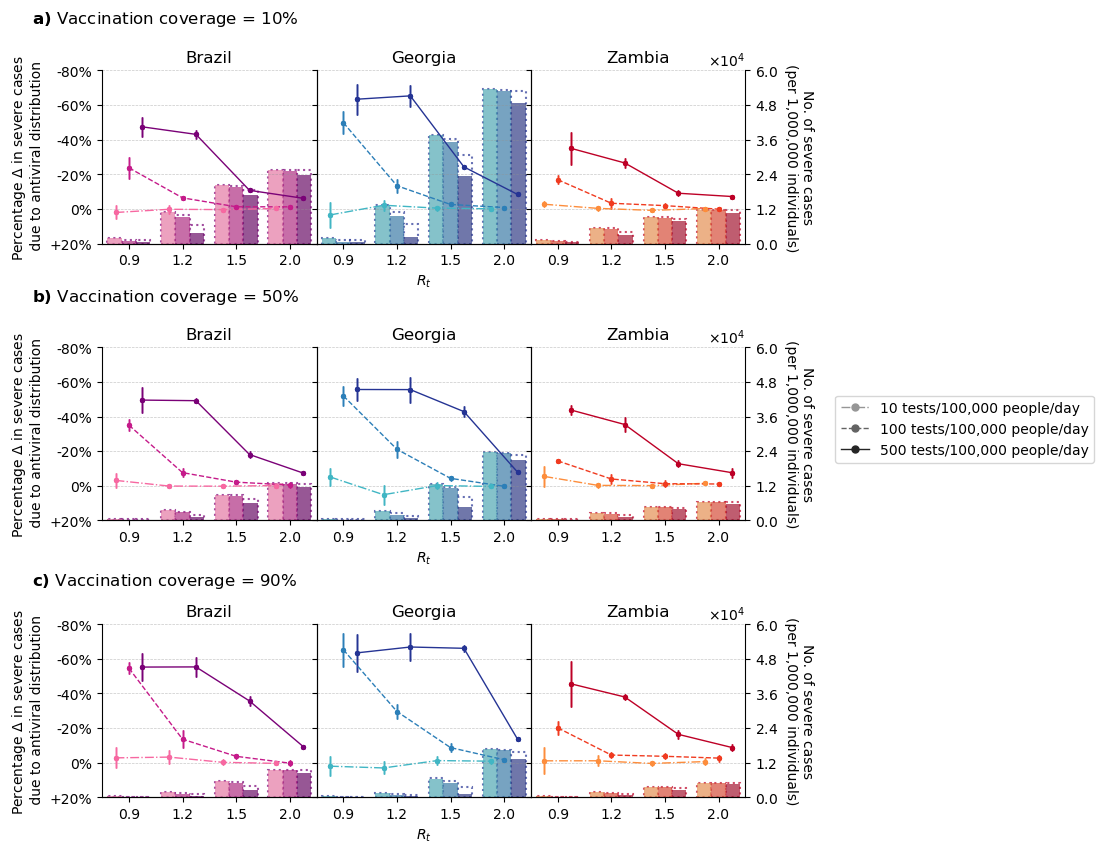

severe_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 1
0.1 brazil


severe_n_averted_p
ntest Rt                     
10    0.9           -2.039891
      1.2           -2.033955
      1.5           -0.149221
      2.0           -0.149443
100   0.9            4.010025
      1.2            3.020196
      1.5           -0.118071
      2.0            0.418584
500   0.9           52.920452
      1.2           24.726415
      1.5            5.153637
      2.0            4.736747

0.1 georgia


severe_n_averted_p
ntest Rt                     
10    0.9           -2.594788
      1.2           -0.502249
      1.5            0.026558
      2.0            0.104272
100   0.9           11.709308
      1.2           -0.003671
      1.5           -0.034315
      2.0            0.535547
500   0.9           66.474636
      1.2           59.861082
      1.5            9.518961
      2.0            5.424473

0.1 zambia


severe_n_averted_p
ntest Rt                     
10    0.9           -0.449398
      1.2           -1.312614
      1.5            0.304624
      2.0           -0.136939
100   0.9            5.660808
      1.2            1.397107
      1.5            1.070175
      2.0           -0.277734
500   0.9           39.901904
      1.2           12.269475
      1.5            4.257738
      2.0            4.818314

0.5 brazil


severe_n_averted_p
ntest Rt                     
10    0.9           -1.217558
      1.2           -1.376851
      1.5           -0.075867
      2.0            0.257696
100   0.9            9.541284
      1.2           -0.846215
      1.5            0.570238
      2.0            0.115463
500   0.9           51.944972
      1.2           46.726908
      1.5            8.359100
      2.0            5.146142

0.5 georgia


severe_n_averted_p
ntest Rt                     
10    0.9            4.381353
      1.2           -3.190737
      1.5            0.725455
      2.0           -0.388841
100   0.9           25.558943
      1.2            1.952013
      1.5           -0.042728
      2.0           -0.031676
500   0.9           59.070905
      1.2           61.901935
      1.5           14.055767
      2.0            4.033437

0.5 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            1.186240
      1.2           -0.158922
      1.5            0.784477
      2.0            1.199988
100   0.9            5.045141
      1.2            1.885084
      1.5            0.161092
      2.0           -0.402414
500   0.9           47.022713
      1.2           18.982561
      1.5            6.213873
      2.0            5.299167

0.9 brazil


severe_n_averted_p
ntest Rt                     
10    0.9           -0.817757
      1.2            0.527009
      1.5            1.560304
      2.0            1.235751
100   0.9           26.251025
      1.2            3.411306
      1.5            0.161891
      2.0           -0.010517
500   0.9           57.730263
      1.2           62.355330
      1.5           16.777603
      2.0            5.878946

0.9 georgia


severe_n_averted_p
ntest Rt                     
10    0.9            0.824985
      1.2            0.305283
      1.5            0.209695
      2.0            0.454394
100   0.9           41.653905
      1.2            5.995077
      1.5           -1.494909
      2.0            1.015173
500   0.9           68.460955
      1.2           70.143241
      1.5           40.766185
      2.0            6.172967

0.9 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            0.847458
      1.2           -1.910828
      1.5           -0.304620
      2.0            1.423615
100   0.9           13.572023
      1.2            2.000000
      1.5            3.005910
      2.0            2.418072
500   0.9           52.131439
      1.2           27.913372
      1.5            9.382563
      2.0            6.020433

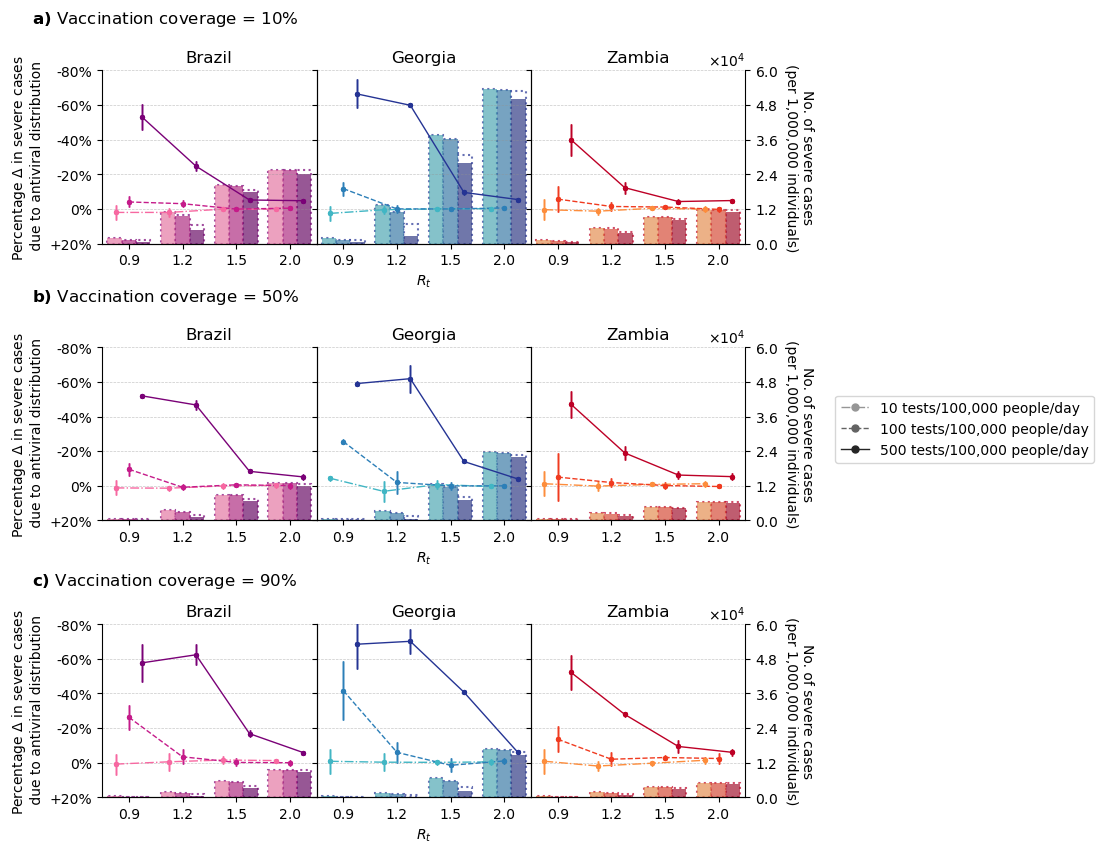

severe_n VE 0 TestProb 0.65 Risk 0.2 SympRes 1 TestAsymp 0
0.1 brazil


severe_n_averted_p
ntest Rt                     
10    0.9            5.133726
      1.2            0.858162
      1.5           -0.284607
      2.0            0.084502
100   0.9           37.656642
      1.2           23.027972
      1.5            7.273364
      2.0            3.974195
500   0.9           28.444280
      1.2           22.984277
      1.5           43.805910
      2.0           34.503700

0.1 georgia


severe_n_averted_p
ntest Rt                     
10    0.9           -0.447377
      1.2            1.355322
      1.5            0.385098
      2.0            0.219756
100   0.9           56.819965
      1.2           34.510351
      1.5            7.582466
      2.0            2.710715
500   0.9           54.072652
      1.2           50.882521
      1.5           55.738353
      2.0           25.454052

0.1 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            4.745641
      1.2            0.497258
      1.5            0.604865
      2.0           -0.918703
100   0.9           24.766035
      1.2           28.045196
      1.5           13.015351
      2.0            7.320652
500   0.9            6.664743
      1.2           18.865263
      1.5           34.739431
      2.0           37.690197

0.5 brazil


severe_n_averted_p
ntest Rt                     
10    0.9            4.517783
      1.2            2.408118
      1.5            1.218342
      2.0            0.475030
100   0.9           35.825688
      1.2           32.489339
      1.5           10.990244
      2.0            5.476673
500   0.9           31.593928
      1.2           20.863454
      1.5           41.916490
      2.0           38.017338

0.5 georgia


severe_n_averted_p
ntest Rt                     
10    0.9            5.432878
      1.2           -5.654551
      1.5            0.617342
      2.0           -0.196967
100   0.9           43.495935
      1.2           49.662464
      1.5           12.365619
      2.0            2.582015
500   0.9           45.330073
      1.2           40.330049
      1.5           45.455896
      2.0           27.187185

0.5 zambia


severe_n_averted_p
ntest Rt                     
10    0.9            6.247529
      1.2            0.575148
      1.5            0.312956
      2.0            0.973047
100   0.9           26.022305
      1.2           32.458018
      1.5           16.359320
      2.0            9.198944
500   0.9           15.776550
      1.2           16.827724
      1.5           37.874819
      2.0           42.025910

0.9 brazil


severe_n_averted_p
ntest Rt                     
10    0.9            6.950935
      1.2            3.381643
      1.5            1.841439
      2.0           -0.043762
100   0.9           45.939295
      1.2           54.177109
      1.5           18.214676
      2.0            6.272481
500   0.9           42.598684
      1.2           31.329949
      1.5           40.140237
      2.0           46.471774

0.9 georgia


severe_n_averted_p
ntest Rt                     
10    0.9            5.008839
      1.2            2.428989
      1.5            1.647166
      2.0            0.529530
100   0.9           56.661562
      1.2           65.101969
      1.5           24.832094
      2.0            5.751844
500   0.9           57.771039
      1.2           54.274843
      1.5           51.752445
      2.0           40.644057

0.9 zambia


severe_n_averted_p
ntest Rt                     
10    0.9           11.985472
      1.2            1.430327
      1.5            0.428725
      2.0            0.693863
100   0.9           28.642798
      1.2           38.353659
      1.5           20.855615
      2.0           11.577315
500   0.9           26.287744
      1.2           17.583362
      1.5           41.774744
      2.0           45.066083

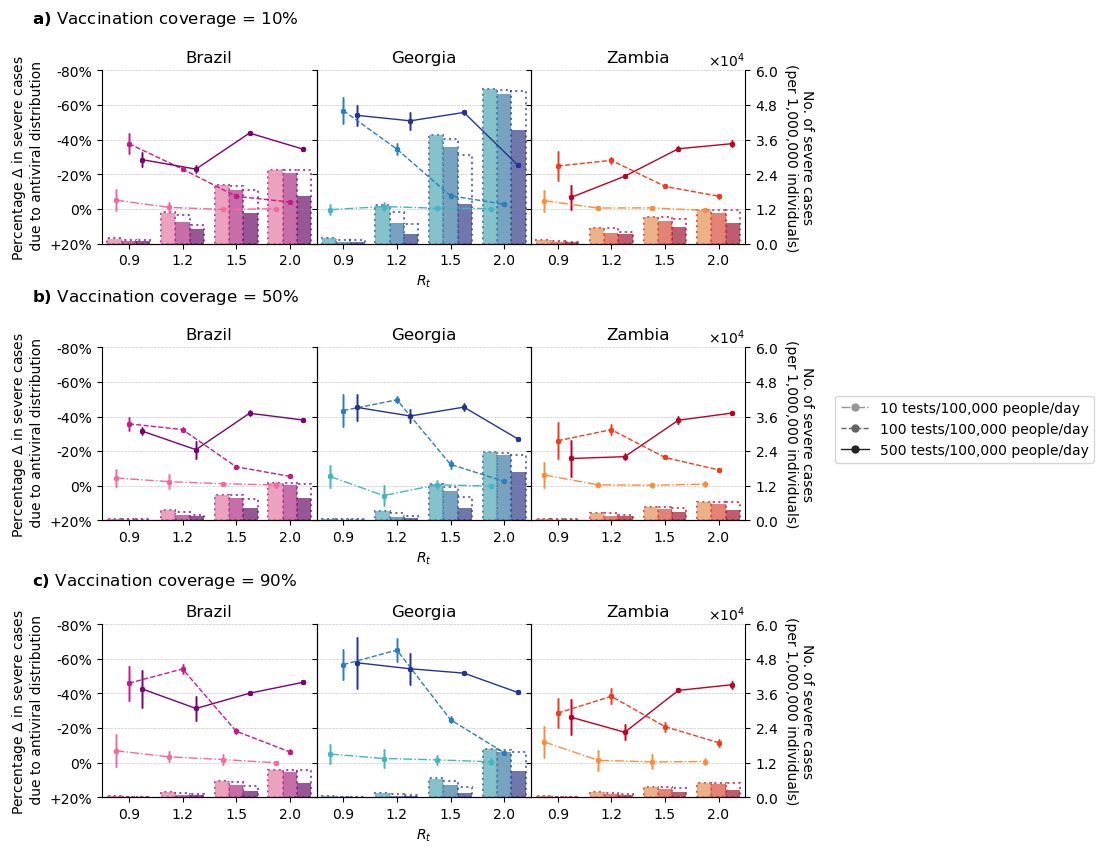

In [9]:
with plt.style.context("default"): 
    no_res_dict = get_averted_plots(var = "severe_n", ylabel = "Percentage " + r"$\Delta$" + " in severe cases\n due to antiviral distribution", 
                      ylabel2 = "No. of severe cases\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=80, ymin2=0., ymax2=6e4, ysep=6,
                      test_asymp=0, symp_restrict=0, fname='Figure1', 
                      print_table=True)
    
    asymp_no_res_dict = get_averted_plots(var = "severe_n", ylabel = "Percentage " + r"$\Delta$" + " in severe cases\n due to antiviral distribution", 
                      ylabel2 = "No. of severe cases\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=80, ymin2=0., ymax2=6e4, ysep=6,
                      test_asymp=1, symp_restrict=0, fname='FigureS6', 
                      print_table=True)
    
    res_dict = get_averted_plots(var = "severe_n", ylabel = "Percentage " + r"$\Delta$" + " in severe cases\n due to antiviral distribution", 
                      ylabel2 = "No. of severe cases\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=80, ymin2=0., ymax2=6e4, ysep=6,
                      test_asymp=0, symp_restrict=1, fname='Figure2', 
                      print_table=True)

In [10]:
from scipy.stats import norm

full_df = []
for vacc_prob, country_to_df in no_res_dict.items(): 
    for country in country_list[:3]: 
        df = country_to_df[country].reset_index()
        df['country'] = country
        df['vacc_prob'] = vacc_prob
        full_df.append(df)
full_df = pd.concat(full_df, ignore_index=True)[['country', 'vacc_prob', 'Rt', 'ntest', 'severe_n_averted_p', 'severe_n_averted_p_sd']]

effect_of_vacc_on_sev_case_averted_by_av = []
for country in country_list[:3]: 
    country_df = full_df[full_df['country']==country].copy()
    country_df = country_df[country_df['ntest']>10]
    for ntest in [100, 500]: 
        test_country_df = country_df[country_df['ntest']==ntest].set_index('Rt').sort_index()
        test_country_df.loc[test_country_df[test_country_df['severe_n_averted_p']<0.].index, 'severe_n_averted_p'] = 0.
        fold_change = (test_country_df[test_country_df['vacc_prob']==0.9]['severe_n_averted_p']/test_country_df[test_country_df['vacc_prob']==0.1]['severe_n_averted_p']).reset_index()
        fold_change['country'] = country
        fold_change['ntest'] = ntest
        
        effect_of_vacc_on_sev_case_averted_by_av.append(fold_change)
effect_of_vacc_on_sev_case_averted_by_av = pd.concat(effect_of_vacc_on_sev_case_averted_by_av, ignore_index=True)[['country', 'ntest', 'Rt', 'severe_n_averted_p']]
effect_of_vacc_on_sev_case_averted_by_av = effect_of_vacc_on_sev_case_averted_by_av.set_index(['country', 'ntest', 'Rt'])
effect_of_vacc_on_sev_case_averted_by_av['severe_n_averted_p']
effect_of_vacc_on_sev_case_averted_by_av.to_csv('./data/Table1a.csv')

##### 

full_df1 = []
for vacc_prob, country_to_df in res_dict.items(): 
    for country in country_list[:3]: 
        df = country_to_df[country].reset_index()
        df['country'] = country
        df['vacc_prob'] = vacc_prob
        full_df1.append(df)
full_df1 = pd.concat(full_df1, ignore_index=True)[['country', 'vacc_prob', 'Rt', 'ntest', 'severe_n_averted_p', 'severe_n_averted_p_sd']]

full_df = full_df[(full_df['ntest']==100)&(full_df['Rt']>=1.5)]
full_df1 = full_df1[(full_df1['ntest']==100)&(full_df1['Rt']>=1.5)]

full_df = full_df.set_index(['country', 'vacc_prob', 'Rt', 'ntest']).sort_index()
full_df1 = full_df1.set_index(['country', 'vacc_prob', 'Rt', 'ntest']).sort_index()
#full_df.loc[full_df[full_df['severe_n_averted_p']<0].index, 'severe_n_averted_p'] = 0
ratio_df = full_df1['severe_n_averted_p'] / full_df['severe_n_averted_p']
ratio_df = ratio_df.to_numpy()
ratio_df = ratio_df[ratio_df>0]
print (np.median(ratio_df), np.quantile(ratio_df, .25), np.quantile(ratio_df, .75))

4.931702344546384 3.344661360780227 6.3998577494010895


## Deaths

deaths_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 0
0.1 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9           -2.585194
      1.2            3.272278
      1.5            1.980602
      2.0            1.137761
100   0.9           32.059801
      1.2            9.084589
      1.5            2.940256
      2.0            0.171473
500   0.9           67.490494
      1.2           62.819203
      1.5           15.930137
      2.0            7.233768

0.1 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9          -10.299296
      1.2            2.265861
      1.5           -0.919692
      2.0            0.152115
100   0.9           62.250879
      1.2           16.489860
      1.5            5.891273
      2.0            1.648399
500   0.9           69.925743
      1.2           74.179537
      1.5           31.534301
      2.0           10.639305

0.1 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9            8.737864
      1.2            0.990508
      1.5           -4.331361
      2.0            1.500268
100   0.9           33.004926
      1.2            4.430930
      1.5            1.246179
      2.0            2.171205
500   0.9           58.823529
      1.2           44.735240
      1.5           16.244037
      2.0           11.593945

0.5 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9            6.065574
      1.2            3.886490
      1.5           -1.075269
      2.0           -0.414600
100   0.9           48.984772
      1.2           11.250983
      1.5            4.095262
      2.0            0.619528
500   0.9           65.947242
      1.2           68.696121
      1.5           27.377023
      2.0           11.280539

0.5 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9           -0.129702
      1.2           -4.360020
      1.5            0.473007
      2.0           -0.557184
100   0.9           66.371681
      1.2           28.778601
      1.5            5.419106
      2.0            0.960852
500   0.9           68.123862
      1.2           71.203953
      1.5           57.511952
      2.0           12.977022

0.5 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9            4.398148
      1.2            4.074941
      1.5           -1.019647
      2.0            1.716738
100   0.9           35.905045
      1.2           10.919849
      1.5            0.950668
      2.0           -0.055351
500   0.9           69.824561
      1.2           58.292167
      1.5           19.435646
      2.0           13.008280

0.9 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9            9.205021
      1.2            2.449168
      1.5            0.439727
      2.0           -1.283708
100   0.9           63.190184
      1.2           20.493247
      1.5            5.878511
      2.0            0.112622
500   0.9           61.165049
      1.2           66.293930
      1.5           50.352423
      2.0           13.614060

0.9 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9            1.007194
      1.2           -5.573770
      1.5            2.728600
      2.0            0.100440
100   0.9           74.018692
      1.2           33.300971
      1.5           10.329308
      2.0            3.024377
500   0.9           69.754253
      1.2           73.975045
      1.5           72.772109
      2.0           18.936902

0.9 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9            1.058201
      1.2            7.298475
      1.5           -2.861815
      2.0            1.203035
100   0.9           28.458498
      1.2            7.277138
      1.5            5.946960
      2.0            6.481822
500   0.9           67.158672
      1.2           60.791058
      1.5           24.260532
      2.0           16.405082

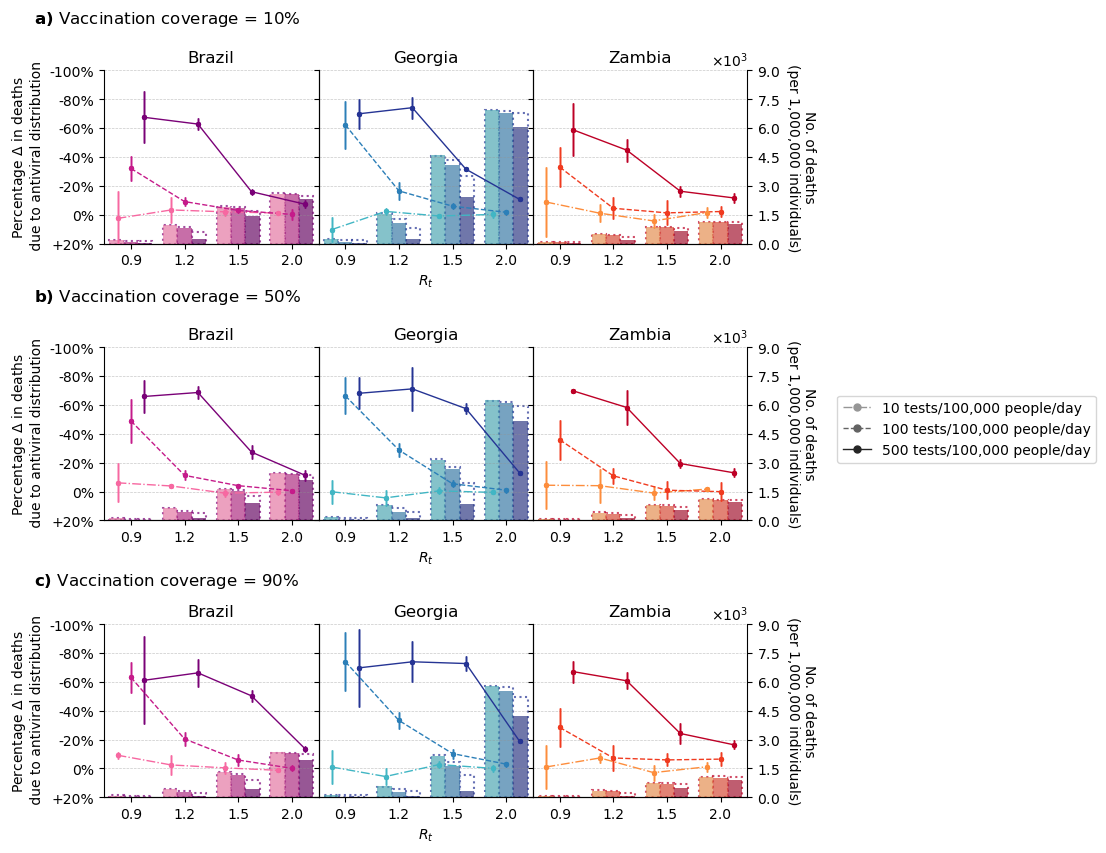

deaths_n VE 0 TestProb 0.65 Risk 0.2 SympRes 0 TestAsymp 1


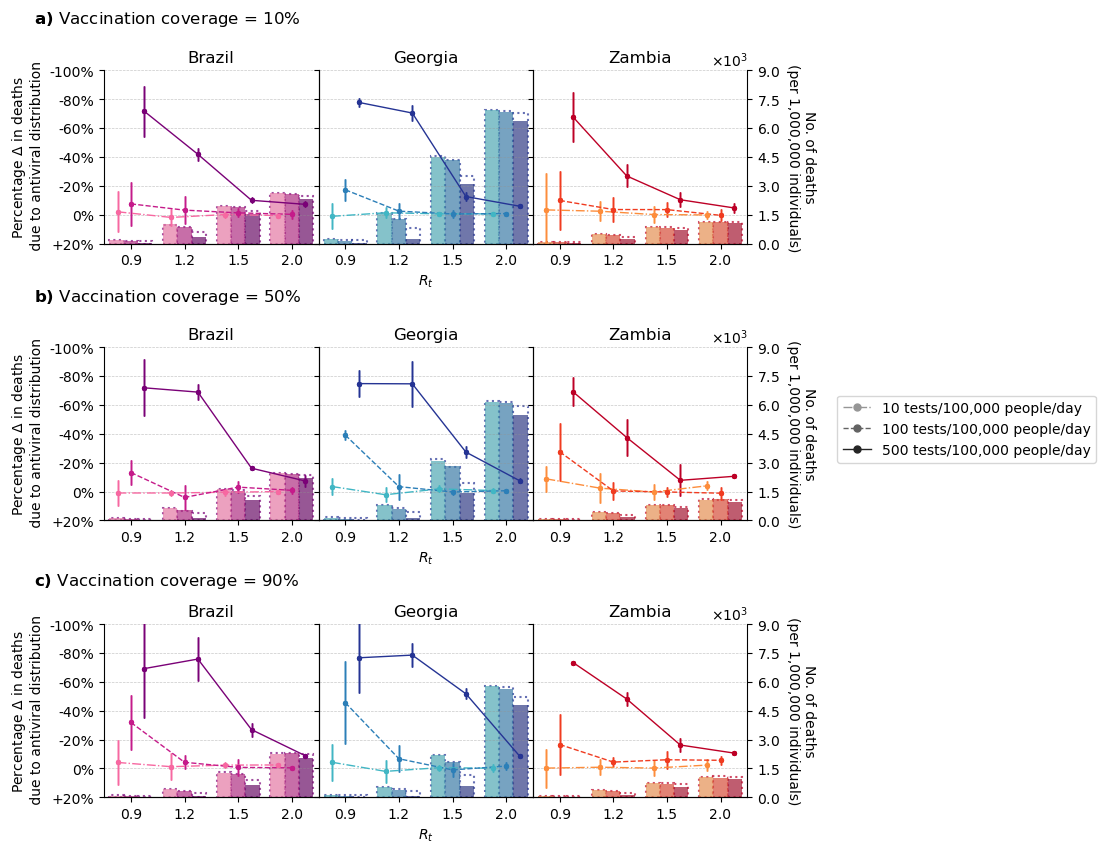

deaths_n VE 0 TestProb 0.65 Risk 0.2 SympRes 1 TestAsymp 0
0.1 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9            4.700353
      1.2            1.913974
      1.5            1.214906
      2.0            1.253075
100   0.9           58.803987
      1.2           35.272306
      1.5           13.356272
      2.0            5.276695
500   0.9           50.190114
      1.2           51.481103
      1.5           61.821592
      2.0           51.232479

0.1 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9           -1.936620
      1.2            2.593152
      1.5            0.259626
      2.0            0.751966
100   0.9           67.409144
      1.2           41.404056
      1.5           11.552778
      2.0            3.661182
500   0.9           59.529703
      1.2           63.875483
      1.5           65.619129
      2.0           30.871134

0.1 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9            5.436893
      1.2           -3.962031
      1.5            0.923077
      2.0           -0.982318
100   0.9           54.679803
      1.2           52.693310
      1.5           20.714790
      2.0           12.956042
500   0.9           47.647059
      1.2           46.135119
      1.5           61.159930
      2.0           62.119323

0.5 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9           11.311475
      1.2            3.423812
      1.5            1.717958
      2.0            1.064954
100   0.9           54.060914
      1.2           47.482297
      1.5           18.535786
      2.0            7.723443
500   0.9           57.793765
      1.2           52.047414
      1.5           60.443187
      2.0           55.037911

0.5 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9            3.761349
      1.2           -4.538501
      1.5            1.797427
      2.0            0.376824
100   0.9           63.362832
      1.2           62.810184
      1.5           16.014565
      2.0            4.320587
500   0.9           63.387978
      1.2           61.680144
      1.5           62.974265
      2.0           38.716071

0.5 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9           13.888889
      1.2            2.107728
      1.5            2.064163
      2.0            4.703147
100   0.9           53.412463
      1.2           57.073696
      1.5           29.110997
      2.0           15.202952
500   0.9           59.298246
      1.2           45.095272
      1.5           59.458681
      2.0           63.127875

0.9 brazil


deaths_n_averted_p
ntest Rt                     
10    0.9           16.527197
      1.2            2.449168
      1.5            0.849128
      2.0           -0.404928
100   0.9           65.030675
      1.2           64.885496
      1.5           24.706074
      2.0            7.441740
500   0.9           64.724919
      1.2           55.031949
      1.5           56.343612
      2.0           60.201624

0.9 georgia


deaths_n_averted_p
ntest Rt                     
10    0.9            7.769784
      1.2            1.056466
      1.5            1.168096
      2.0            0.121221
100   0.9           68.224299
      1.2           71.504854
      1.5           30.164654
      2.0            7.665712
500   0.9           68.052930
      1.2           64.230541
      1.5           61.955782
      2.0           49.674952

0.9 zambia


deaths_n_averted_p
ntest Rt                     
10    0.9           24.074074
      1.2            9.368192
      1.5           -1.090215
      2.0           -0.795854
100   0.9           47.826087
      1.2           59.975743
      1.5           33.110099
      2.0           18.417187
500   0.9           56.457565
      1.2           42.992261
      1.5           60.113535
      2.0           63.976084

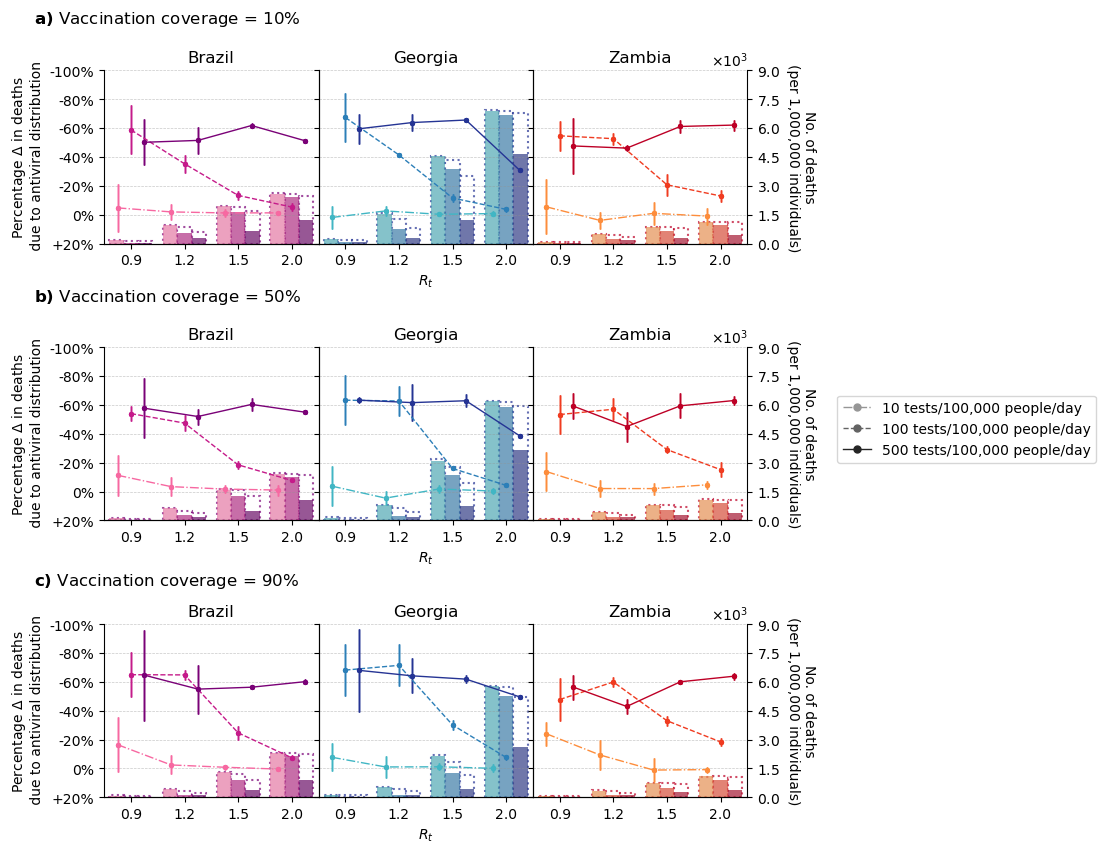

In [11]:
with plt.style.context("default"): 
    get_averted_plots(var = "deaths_n", ylabel = "Percentage " + r"$\Delta$" + " in deaths\n due to antiviral distribution", 
                      ylabel2 = "No. of deaths\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=100, ymin2=0., ymax2=.9e4, ysep=7,
                      test_asymp=0, symp_restrict=0, fname='FigureS4', print_table=True)
    
    get_averted_plots(var = "deaths_n", ylabel = "Percentage " + r"$\Delta$" + " in deaths\n due to antiviral distribution", 
                      ylabel2 = "No. of deaths\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=100, ymin2=0., ymax2=.9e4, ysep=7,
                      test_asymp=1, symp_restrict=0, fname='FigureS7')
    
    get_averted_plots(var = "deaths_n", ylabel = "Percentage " + r"$\Delta$" + " in deaths\n due to antiviral distribution", 
                      ylabel2 = "No. of deaths\n(per 1,000,000 individuals)",
                      ymin=-20, ymax=100, ymin2=0., ymax2=.9e4, ysep=7,
                      test_asymp=0, symp_restrict=1, fname='FigureS9', print_table=True)

## Impact of antivirals in the Netherlands

infected_n_averted_p
ntest Rt                       
100   0.9             13.802263
      1.2             12.407323
      1.5              9.387835
      2.0              1.081730
500   0.9             10.470171
      1.2             12.938747
      1.5             10.478685
      2.0              4.405239

severe_n_averted_p
ntest Rt                     
100   0.9           60.363947
      1.2           59.666545
      1.5           43.614225
      2.0           13.932560
500   0.9           58.130448
      1.2           59.271399
      1.5           59.217274
      2.0           56.380446

deaths_n_averted_p
ntest Rt                     
100   0.9           69.107744
      1.2           71.009226
      1.5           54.972465
      2.0           18.748657
500   0.9           69.625762
      1.2           70.359875
      1.5           69.058925
      2.0           67.109835

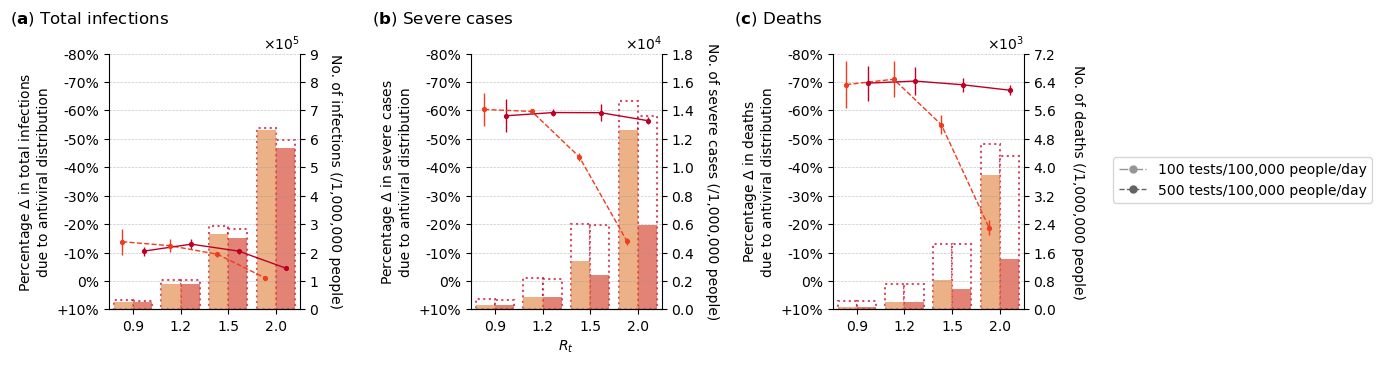

In [12]:
simdata = pd.read_csv('./data/simdata_netherlands.csv')
summary_df = pd.read_csv('./data/summary_netherlands.csv')

def plot_hic(symp_restrict, test_asymp, fname=None, test_prob = 0.1, vacc_prob = 0.8, vacc_eff = 0, risk_prev = 0.2): 

    ylabel_arr = ["Percentage " + r"$\Delta$" + " in total infections\ndue to antiviral distribution",
                  "Percentage " + r"$\Delta$" + " in severe cases\ndue to antiviral distribution",
                  "Percentage " + r"$\Delta$" + " in deaths\ndue to antiviral distribution"]
    ylabel2_arr = ['No. of infections (/1,000,000 people)', 'No. of severe cases (/1,000,000 people)', 'No. of deaths (/1,000,000 people)']
    title_arr = ["Total infections", "Severe cases", 'Deaths']

    with plt.style.context("default"): 
        fig = plt.figure(figsize=(11.8, 8.3 * 0.4))
        gs = GridSpec(nrows=1, ncols=3, wspace=.9)

        for v, var in enumerate(['infected_n', 'severe_n', 'deaths_n']):
            ax = fig.add_subplot(gs[v])

            # filter data
            fdf = summary_df[(summary_df['vacc_prob']==vacc_prob)&(summary_df['vacc_eff']==vacc_eff)&(summary_df['test_prob']==test_prob)&(summary_df['risk_prev']==risk_prev)].copy()
            simdata_fdf = simdata[(simdata['vacc_prob']==vacc_prob)&(simdata['vacc_eff']==vacc_eff)&(simdata['test_prob']==test_prob)&(simdata['risk_prev']==risk_prev)].copy()

            base_df = fdf[(fdf['baseline']>0)].copy()
            base_df = base_df.set_index(['ntest', 'Rt']).sort_index()
            ana_df = fdf[(fdf['baseline']==0)&(fdf['test_asymp']==test_asymp)&(fdf['symp_restrict']==symp_restrict)].copy()
            curr_ana_df = ana_df.set_index(['ntest', 'Rt']).sort_index()

            base_simdata_df = simdata_fdf[(simdata_fdf['baseline']>0)].copy()
            base_simdata_df = base_simdata_df.set_index(['ntest', 'Rt']).sort_index()
            ana_simdata_df = simdata_fdf[(simdata_fdf['baseline']==0)&(simdata_fdf['test_asymp']==test_asymp)&(simdata_fdf['symp_restrict']==symp_restrict)].copy()
            curr_ana_simdata_df = ana_simdata_df.set_index(['ntest', 'Rt']).sort_index()
            
            # match indices 
            """
            common_indices = list(set(curr_ana_df.index)&set(base_df.index))
            curr_ana_df = curr_ana_df[curr_ana_df.index.isin(common_indices)]
            base_df = base_df[base_df.index.isin(common_indices)]

            common_indices = list(set(curr_ana_simdata_df.index)&set(base_simdata_df.index))
            curr_ana_simdata_df = curr_ana_simdata_df[curr_ana_simdata_df.index.isin(common_indices)]
            base_simdata_df = base_simdata_df[base_simdata_df.index.isin(common_indices)] 
            """

            y = curr_ana_df[var].to_numpy()
            y_sd = curr_ana_df[var+"_sd"].to_numpy()

            # compute averted ratio stats 
            y_base = base_df[var].to_numpy()
            y_base_sd = base_df[var+"_sd"].to_numpy()

            # compute covariance of y and y_base 
            cov_y_ybase = np.array([np.cov(base_simdata_df.loc[idx, var], curr_ana_simdata_df.loc[idx, var])[0,1] for idx in curr_ana_df.index])

            # compute mean and sd of numerator 
            num_sd = np.sqrt(y_base_sd**2 + y_sd**2 - 2*cov_y_ybase)
            num_mean = (y_base - y)

            plot_label = var+'_averted_n'
            curr_ana_df[plot_label] = num_mean
            curr_ana_df[plot_label+"_sd"] = num_sd

            num_mean[num_mean==0.] = 1e-6 
            # approximate sd of ratio 
            ratio_sd = num_mean**2/y_base**2 * (num_sd**2/num_mean**2 - (2 * cov_y_ybase/(num_mean*y_base)) + y_base_sd**2/y_base**2)
            ratio_sd = abs(ratio_sd)
            ratio_sd = 100*np.sqrt(ratio_sd)

            # compute averted y ratio
            y = 100*((y_base-y)/y_base)
            plot_label = var+'_averted_p'
            curr_ana_df[plot_label] = y
            curr_ana_df[plot_label+"_sd"] = ratio_sd

            # plot 
            ntest_list = sorted(curr_ana_df.index.get_level_values(0).unique())
            ntest_cols = country_cols[country]
            
            for k, ntest in enumerate(ntest_list):
                k += 1
                plot_x = np.array(sorted(curr_ana_df.loc[ntest].index.get_level_values(0)))
                try: 
                    plot_y = curr_ana_df.loc[ntest].loc[plot_x, plot_label]
                except: 
                    continue 

                plot_y_sd = curr_ana_df.loc[ntest].loc[plot_x, plot_label+"_sd"]

                #print (country, vacc_eff, vacc_prob, var, symp_restrict, )
                plot_x = np.searchsorted(Rt_arr, plot_x)       
                ax.errorbar(np.array(plot_x)+(0.45*(k-1.5)), plot_y, yerr=plot_y_sd, c=ntest_cols[k], lw=1., ls=ntest_linestyles[k], zorder=100)
                ax.scatter(np.array(plot_x)+(0.45*(k-1.5)), plot_y, color=ntest_cols[k], s=30, marker=".", zorder=200)
            
            display (curr_ana_df[[plot_label]])
            
            # cosmetics 
            ymin, ymax, ysep = -10, 80, 10
            ax.set_ylim(ymin, ymax)
            ax.set_yticks(np.linspace(ymin, ymax, ysep))
            yticklabels = ["%i%%"%(-y) if y >= 0 else "+%i%%"%(abs(y)) for y in np.linspace(ymin, ymax, ysep)]
            ax.set_yticklabels(yticklabels)
            ax.grid(axis='y', ls='--', lw=0.5, c='#929292', zorder=-100, alpha=0.5)
            ax.set_xticks(np.arange(4))
            ax.set_xticklabels(Rt_arr)
            if v == 1: 
                ax.set_xlabel(r"$R_t$", fontsize=10)
            ax.set_ylabel(ylabel_arr[v], fontsize=10)    
            for axis in ['top', 'right']:
                ax.spines[axis].set_visible(False)

            # plot actual number of cases averted 
            ax2 = ax.twinx()
            f = sns.barplot(x="Rt", y=var, hue="ntest", data=base_df.reset_index(), ax=ax2, 
                            zorder=0, facecolor=(1, 1, 1, 0), linewidth=1.5,
                            linestyle='dotted',
                            edgecolor=country_cols[country][-1], 
                            alpha=0.7)# capsize=.2)
            f.legend_.remove()

            plot_df = curr_ana_df.copy().reset_index()
            g = sns.barplot(x="Rt", y=var, hue="ntest", data=plot_df, ax=ax2, 
                            zorder=1, palette=country_cols[country], alpha=0.7)# capsize=.2)
            g.legend_.remove()
            if v == 0: 
                ymin2, ymax2 = 0., 9e5
            elif v == 1:  
                ymin2, ymax2 = 0., 18000
            else: 
                ymin2, ymax2 = 0., 7200           
            ax2.set_ylim(ymin2, ymax2)
            ax2.set_yticks(np.linspace(ymin2, ymax2, ysep))

            for axis in ['top', 'left']:
                ax2.spines[axis].set_visible(False)

            ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
            ax2.set_ylabel(ylabel2_arr[v], rotation=270, va='top', ha='center', fontsize=10)
            if v == 0: 
                ax2.yaxis.set_label_coords(1.22,0.5)
            elif v == 1: 
                ax2.yaxis.set_label_coords(1.3,0.5)
            else: 
                ax2.yaxis.set_label_coords(1.32,0.5)

            ax.set_zorder(ax2.get_zorder()+1)
            ax.patch.set_visible(False)

            ax.text(s='(' + r'$\bf{%s}$'%(string.ascii_lowercase[v]) + ') %s'%(title_arr[v]), ha='left', 
                    x=-0.52, y=1.12, transform=ax.transAxes, fontsize=12)
        
        # legend 
        legend_elements = []
        for i, ntest in enumerate(ntest_list):
            if ntest < 100: 
                continue 
            legend_elements.append(Line2D([0], [0], marker='o', color=['#969696','#636363','#252525'][i], 
                                          label='%i tests/100,000 people/day'%(ntest),
                                          markerfacecolor=['#969696','#636363','#252525'][i], lw=1., ls=ntest_linestyles[i],
                                          markersize=5),)
        fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.97, 0.5))
        if fname != None: 
            plt.savefig("./figures/%s.png"%(fname), dpi=600, bbox_inches='tight')
        plt.show()
    return 

plot_hic(symp_restrict = 0, test_asymp = 0, fname="Figure3")

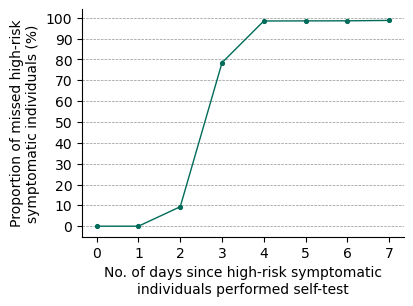

In [13]:
def plot_days_late(symp_restrict = 0, test_asymp = 0, fname=None, test_prob = 0.1, vacc_prob = 0.8, vacc_eff = 0, risk_prev = 0.2): 
    simdata_df = pd.read_csv('./data/simdata_netherlands.csv')
    simdata_df = simdata_df[simdata_df['baseline']<1]
    fdf = simdata_df[(simdata_df['symp_restrict']==symp_restrict)&(simdata_df['test_asymp']==test_asymp)&(simdata_df['vacc_prob']==vacc_prob)&(simdata_df['vacc_eff']==vacc_eff)&(simdata_df['test_prob']==test_prob)&(simdata_df['risk_prev']==risk_prev)].copy()
    
    with plt.style.context("default"): 
        fig, ax = plt.subplots(1, 1, figsize=(8.3/2, 11.8*0.25))
        x = np.arange(8)
        y = (1 - fdf[days_late_vars].mean(axis=0).to_numpy()) * 100
        y_sd = fdf[days_late_vars].std(axis=0, ddof=1).to_numpy() * 100
        
        ax.errorbar(x, y, yerr=y_sd,  c=country_cols['netherlands'][-1], lw=1., ls='-', zorder=100)
        ax.scatter(x, y, color=country_cols['netherlands'][-1], s=30, marker=".", zorder=200)

        ax.set_xticks(np.arange(8))
        ax.set_yticks(np.linspace(0, 100, 11))
        ax.set_xlabel('No. of days since high-risk symptomatic\nindividuals performed self-test')
        ax.set_ylabel('Proportion of missed high-risk\nsymptomatic individuals (%)')
        
        for axis in ['top', 'right']: 
            ax.spines[axis].set_visible(False)
        ax.grid(axis='y', ls='--', lw=0.5, zorder=-100, c='#929292')
        plt.savefig('./figures/FigureS10.png', dpi=600, bbox_inches='tight')
        plt.show()
    
    return 

plot_days_late()

## Antiviral demand and the number of severe cases averted per antiviral

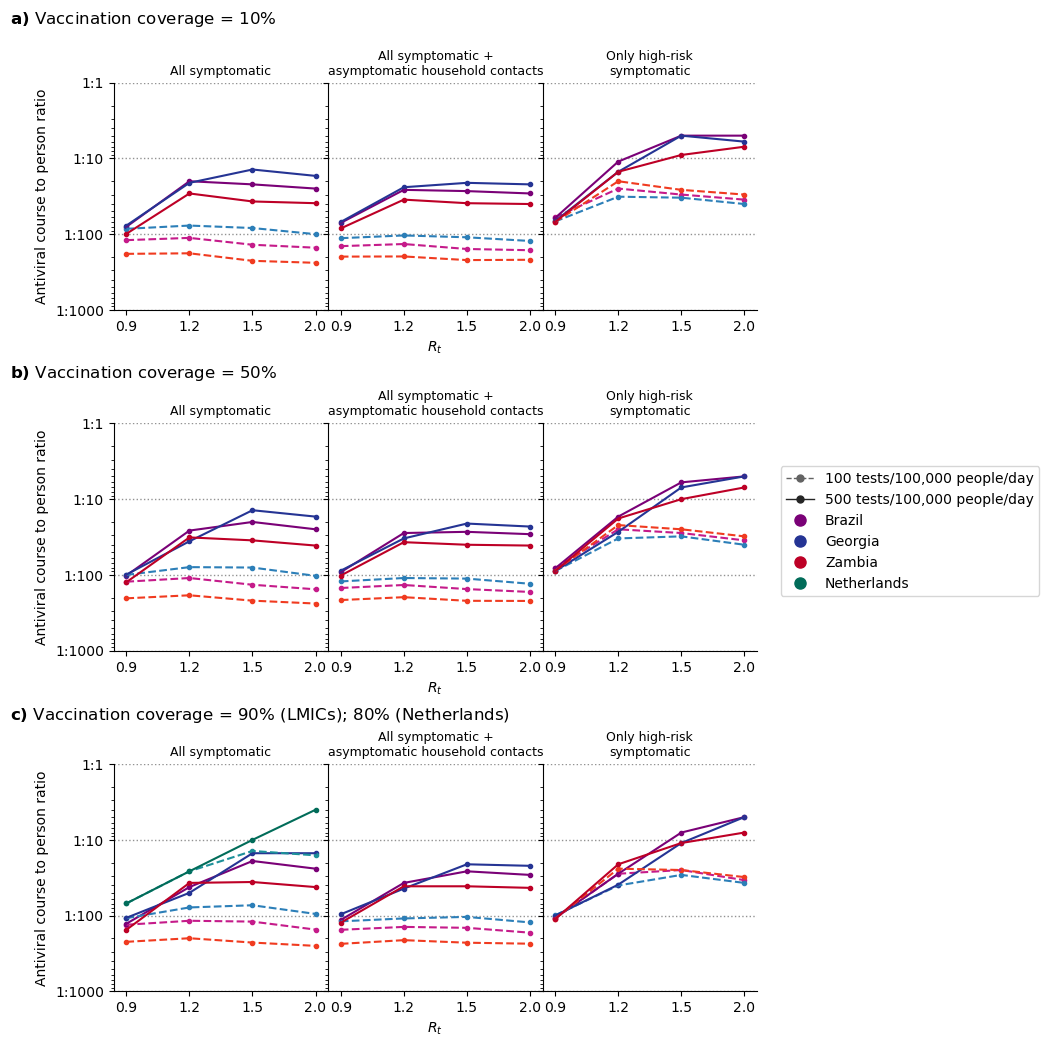

In [14]:
print_table = []

with plt.style.context("default"): 
    fig = plt.figure(figsize=(8.3, 11.8))
    gs = GridSpec(nrows=3, ncols=3, wspace=0., hspace=0.5)
    axes = {}
    
    vacc_eff = 0
    risk_prev = 0.2
    Rt_arr = [0.9, 1.2, 1.5, 2.0]
    ntest_list = [10, 100, 500]
    tm_label = {(0,0):"All symptomatic", 
                (0,1):"All symptomatic +\nasymptomatic household contacts", 
                (1,0):"Only high-risk\nsymptomatic"}
    tm_to_marker = {(0,0):"o", (0,1):"x", (1,0):"d"}
    
    for c, country in enumerate(country_list): 
        if country == 'netherlands': 
            test_prob = 0.1
            vacc_prob_arr = [0.8]
            ntest_arr = [100, 500]
            testing_mode = [(0, 0)] # (symp_restrict, test_asymp)
        else: 
            test_prob = 0.65 
            vacc_prob_arr = [0.1, 0.5, 0.9]
            ntest_arr = [100, 500]
            testing_mode = [(0, 0), (0, 1), (1, 0)] # (symp_restrict, test_asymp)
        
        simdata_df = pd.read_csv('./data/simdata_%s.csv'%(country))
        simdata_ana_df = simdata_df[simdata_df['baseline']<1].copy() # analysis results only 

        summary_df = pd.read_csv("./data/summary_%s.csv"%(country))
        summary_ana_df = summary_df[summary_df['baseline']<1].copy()

        curr_summary_ana_df = summary_ana_df[(summary_ana_df['vacc_eff'] == vacc_eff)&(summary_ana_df['risk_prev'] == risk_prev)&(summary_ana_df['test_prob'] == test_prob)].copy()
        curr_summary_ana_df['av_disbured_rate'] = curr_summary_ana_df['av_disbured_rate'] * 10 * 91
        curr_summary_ana_df['av_disbured_rate_sd'] = curr_summary_ana_df['av_disbured_rate_sd'] * 10 * 91

        curr_simdata_ana_df = simdata_ana_df[(simdata_ana_df['vacc_eff'] == vacc_eff)&(simdata_ana_df['risk_prev'] == risk_prev)&(simdata_ana_df['test_prob'] == test_prob)].copy()
        curr_simdata_ana_df['av_disbured_rate'] = curr_simdata_ana_df['av_disbured_rate'] * 10 * 91

        ntest_cols = country_cols[country]
        
        for i, vacc_prob in enumerate(vacc_prob_arr): 
            if country == 'netherlands': 
                i = 2
            for j, (symp_restrict, test_asymp) in enumerate(testing_mode): 
                
                if c > 0: 
                    ax = axes[i][j]
                else: 
                    ax = fig.add_subplot(gs[i,j])
                    try: 
                        axes[i][j] = ax
                    except: 
                        axes[i] = {j:ax}
                
                sum_fdf = curr_summary_ana_df[(curr_summary_ana_df['symp_restrict'] == symp_restrict)&(curr_summary_ana_df['test_asymp'] == test_asymp)&(curr_summary_ana_df['vacc_prob'] == vacc_prob)]
                sim_fdf = curr_simdata_ana_df[(curr_simdata_ana_df['symp_restrict'] == symp_restrict)&(curr_simdata_ana_df['test_asymp'] == test_asymp)&(curr_simdata_ana_df['vacc_prob'] == vacc_prob)]
                
                sum_fdf = sum_fdf[['Rt', 'ntest', 'av_disbured_rate', 'av_disbured_rate_sd']]
                sum_fdf['country'] = country 
                sum_fdf['vacc_prob'] = vacc_prob
                sum_fdf['testing_mode'] = tm_label[(symp_restrict, test_asymp)]
                for wave in np.arange(1,4):
                    sum_fdf['av:person_%i'%(wave)] = 1e6/(sum_fdf['av_disbured_rate'].to_numpy() * wave)
                print_table.append(sum_fdf)
                
                #print_table.append(sum_fdf)
                for ntest in ntest_arr: 
                    ntest_sum_fdf = sum_fdf[sum_fdf['ntest']==ntest]
                    k = ntest_list.index(ntest)
                    
                    av_demand = np.around(ntest_sum_fdf['av_disbured_rate']).astype(int)
                    y = np.around(1e6/(av_demand * 2)).astype(int)

                    ax.plot(np.arange(len(Rt_arr)), y, ls=ntest_linestyles[k], c=ntest_cols[k], alpha=1., zorder=100)
                    ax.scatter(np.arange(len(Rt_arr)), y, c=ntest_cols[k], marker=".", zorder=100)
                
                if c == 0: 
                    ax.set_yscale('log')
                    ax.set_ylim(1e3, 1)
                    ax.set_yticks([1e3, 1e2, 1e1, 1])
                    if j > 0: 
                        ax.set_yticklabels([])
                        if j == 1: 
                            ax.set_xlabel(r"$R_t$")
                    else: 
                        ax.set_yticklabels(["1:%i"%(abs(y)) for y in ax.get_yticks()])
                        ax.set_ylabel("Antiviral course to person ratio")
                        
                    ax.grid(axis='y', ls='dotted', zorder=-100, c='#929292', lw=1.)
                    ax.set_xticks(np.arange(len(Rt_arr)))
                    ax.set_xticklabels(Rt_arr)
                    ax.set_xlim(-0.2, 3.2)
                    for axis in ['top', 'right']: 
                        ax.spines[axis].set_visible(False)
                    ax.set_title(tm_label[(symp_restrict, test_asymp)], fontsize=9)

    fig.text(x=0., y=0.93, s=r"$\bf{a)}$" + " Vaccination coverage = 10%", fontsize=12, transform=fig.transFigure)
    fig.text(x=0., y=0.63, s=r"$\bf{b)}$" + " Vaccination coverage = 50%", fontsize=12, transform=fig.transFigure)
    fig.text(x=0., y=0.34, s=r"$\bf{c)}$" + " Vaccination coverage = 90% (LMICs); 80% (Netherlands)", fontsize=12, transform=fig.transFigure)
    
    legend_elements = []
    for i, ntest in enumerate(ntest_list):
        if ntest < 100: 
            continue 
        k = ntest_list.index(ntest)
        legend_elements.append(Line2D([0], [0], marker='o', color=['#969696','#636363','#252525'][i], 
                                      label='%i tests/100,000 people/day'%(ntest),
                                      markerfacecolor=['#969696','#636363','#252525'][i], lw=1., ls=ntest_linestyles[i],
                                      markersize=5),)
    for country in country_list: 
        legend_elements.append(Line2D([0], [0], color=country_cols[country][-1], #['#969696','#636363','#252525'][i], 
                                      label='%s'%(country.capitalize()), marker='o',
                                      markerfacecolor=country_cols[country][-1], lw=0.,
                                      markersize=8),)
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.92, 0.5))
    plt.savefig('./figures/Figure4.png', bbox_inches='tight')
    plt.show
    
print_table = pd.concat(print_table, ignore_index=True)[['country', 'vacc_prob', 'testing_mode', 'Rt', 'ntest', 'av_disbured_rate', 'av_disbured_rate_sd', 'av:person_1', 'av:person_2', 'av:person_3']]
print_table.to_csv("./data/antiviral_demand.csv", index=False)

In [15]:
ntest_table = print_table.set_index(['country', 'vacc_prob', 'testing_mode', 'Rt']).sort_index()
ntest_table = ntest_table[ntest_table['ntest']>10]
fold_change_ntest = [ntest_table.loc[idx][ntest_table.loc[idx, 'ntest']==500]['av_disbured_rate'].iloc[0]/ntest_table.loc[idx][ntest_table.loc[idx, 'ntest']==100]['av_disbured_rate'].iloc[0] for idx in ntest_table.index] 
#print (set(fold_change_ntest))
print (np.median(fold_change_ntest), np.quantile(fold_change_ntest, .25), np.quantile(fold_change_ntest, .75))

Rt_table = print_table[(print_table['ntest']>10)&(print_table['country']!='netherlands')].set_index(['country', 'vacc_prob', 'testing_mode', 'ntest']).sort_index()
fold_change_Rt = [Rt_table.loc[idx][Rt_table.loc[idx, 'Rt']==2.0]['av_disbured_rate'].iloc[0]/Rt_table.loc[idx][Rt_table.loc[idx, 'Rt']==.9]['av_disbured_rate'].iloc[0] for idx in Rt_table.index] 
print (np.median(fold_change_Rt), np.quantile(fold_change_Rt, .25), np.quantile(fold_change_Rt, .75))

tm_table = print_table[(print_table['ntest']>10)&(print_table['country']!='netherlands')].set_index(['country', 'vacc_prob', 'Rt', 'ntest']).sort_index()
fold_change_tm = [tm_table.loc[idx][tm_table.loc[idx, 'testing_mode']=="Only high-risk\nsymptomatic"]['av_disbured_rate'].iloc[0]/tm_table.loc[idx][tm_table.loc[idx, 'testing_mode']=="All symptomatic"]['av_disbured_rate'].iloc[0] for idx in tm_table.index] 
print (np.median(fold_change_tm), np.quantile(fold_change_tm, .25), np.quantile(fold_change_tm, .75))

country_table = print_table[(print_table['ntest']>10)&(print_table['country']!='netherlands')].set_index(['testing_mode', 'vacc_prob', 'Rt', 'ntest']).sort_index()
fold_change_country = [country_table.loc[idx][country_table.loc[idx, 'country']=="georgia"]['av_disbured_rate'].iloc[0]/country_table.loc[idx][country_table.loc[idx, 'country']=="zambia"]['av_disbured_rate'].iloc[0] for idx in country_table.index] 
print (np.median(fold_change_country), np.quantile(fold_change_country, .25), np.quantile(fold_change_country, .75))

vacc_table = print_table[(print_table['ntest']>10)&(print_table['country']!='netherlands')].set_index(['country', 'Rt', 'testing_mode', 'ntest']).sort_index()
fold_change_vacc = [vacc_table.loc[idx][vacc_table.loc[idx, 'vacc_prob']==.9]['av_disbured_rate'].iloc[0]/vacc_table.loc[idx][vacc_table.loc[idx, 'vacc_prob']==.1]['av_disbured_rate'].iloc[0] for idx in vacc_table.index] 
print (np.median(fold_change_vacc), np.quantile(fold_change_vacc, .25), np.quantile(fold_change_vacc, .75))

4.310791319974067 1.487155069428387 5.76524281921044
2.6048479904528126 0.9662926690120756 4.3484234495002125
2.5659463220730654 1.5207022662983174 4.552617381803223
1.7218550525239342 1.022656985139354 2.041980823044849
0.9314031135719375 0.7029841020035755 0.9986033003226994


## Leung et al. 

In [16]:
leung_df = pd.read_csv("./data/leung_results.csv")
leung_base_df = pd.read_csv('./data/leung_baseline.csv')

100 * ((leung_base_df['severe_n'].mean() - leung_df['severe_n'].mean())/leung_base_df['severe_n'].mean())

18.274148979951793

## Amount of tests required in Matrajt et al.

In [17]:
from scipy.stats import binom

def get_tests_mat(country, test_prob = 0.65, risk_prev = 0.2, vacc_eff = 0):
    summary_data_df = pd.read_csv('./data/summary_%s.csv'%(country))
    base_summary_data = summary_data_df[summary_data_df['baseline']>0]
    base_summary_data = base_summary_data[(base_summary_data['test_prob']==test_prob)&(base_summary_data['risk_prev']==risk_prev)&(base_summary_data['vacc_eff']==vacc_eff)]
    
    # most analogous simulation to Matrajt et al. 
    vacc_prob = 0.1 
    Rt = 2.0 
    fdf = base_summary_data[(base_summary_data['vacc_prob']==vacc_prob)&(base_summary_data['Rt']==Rt)]

    # probability of above 65
    nc_demand = np.load("/Users/alvinhan/Dropbox/ACTA/2022-May-27_country_therapeutics/nc_demand/%s_delta/nc_demand_arr_R%.1f_Vacc%.1f_VaccEff0.npz"%(country, Rt, vacc_prob))['arr_0']
    tests_n_arr = []
    for d in np.arange(91): 
        p_abv_65 = (fdf['d%i_onset_abv65_n'%d]/(fdf['d%i_onset_tot_n'%d] + nc_demand[d])).mean()
        X_abv_65 = np.around(fdf['d%i_onset_abv65_n'%d].mean() * .2).astype(int)
        for n in np.arange(X_abv_65, 1e6): 
            if binom.cdf(X_abv_65, n, p_abv_65) < 0.05: 
                tests_n_arr.append(n)
                print (d, n)
                break 
    print (np.mean(tests_n_arr)/10)
    #raise Exception
    return 

for country in country_list[:3]: 
    get_tests_mat(country)
    

0 2268.0
1 4871.0
2 3973.0
3 1017.0
4 1448.0
5 2808.0
6 3802.0
7 3786.0
8 3583.0
9 4175.0
10 4427.0
11 5129.0
12 5450.0
13 5386.0
14 5538.0
15 6345.0
16 7332.0
17 8053.0
18 8372.0
19 8437.0
20 8438.0
21 8819.0
22 10093.0
23 11230.0
24 11828.0
25 12040.0
26 12066.0
27 11928.0
28 12365.0
29 13631.0
30 14630.0
31 14927.0
32 14973.0
33 14658.0
34 14309.0
35 14489.0
36 15400.0
37 15920.0
38 15806.0
39 15486.0
40 14942.0
41 14322.0
42 14054.0
43 14367.0
44 14524.0
45 14211.0
46 13602.0
47 13011.0
48 12210.0
49 11655.0
50 11577.0
51 11587.0
52 11124.0
53 10495.0
54 9937.0
55 9071.0
56 8480.0
57 8241.0
58 7984.0
59 7617.0
60 7190.0
61 6711.0
62 5988.0
63 5509.0
64 5149.0
65 5255.0
66 4781.0
67 4474.0
68 4314.0
69 3839.0
70 3403.0
71 3281.0
72 3304.0
73 3058.0
74 2928.0
75 2642.0
76 2361.0
77 2391.0
78 2312.0
79 1932.0
80 2013.0
81 1918.0
82 1584.0
83 2102.0
84 1816.0
85 1430.0
86 1359.0
87 2098.0
88 1635.0
89 1685.0
90 1896.0
761.1043956043957
0 1489.0
1 3544.0
2 3592.0
3 1273.0
4 1353.0
5 253

In [108]:
for country in country_list[:3]: 
    summary_df = pd.read_csv('./data/summary_%s.csv'%(country))
    summary_df = summary_df[(summary_df['Rt']==2.0)&(summary_df['vacc_prob']==.1)&(summary_df['vacc_eff']==0)&(summary_df['ntest']==500)&(summary_df['symp_restrict']>0)]
    summary_df = summary_df[(summary_df['test_prob']==0.65)&(summary_df['risk_prev']==0.2)&(summary_df['test_asymp']==0)]
    initiated_arr = np.array([summary_df["d%i_HR_initiated_av"%day].iloc[0]/summary_df["d%i_HR_w_mild"%day].iloc[0] for day in np.arange(91)])
    initiated_arr = initiated_arr[initiated_arr>0.]
    print (country, 100*np.mean(initiated_arr),)

brazil 19.35224869334984
georgia 19.356072074218417
zambia 20.06914898287962


In [113]:
from scipy.stats import binom

def get_tests_mat(country, test_prob = 0.1, risk_prev = 0.2, vacc_eff = 0):
    summary_data_df = pd.read_csv('./data/summary_%s.csv'%(country))
    base_summary_data = summary_data_df[summary_data_df['baseline']>0]
    base_summary_data = base_summary_data[(base_summary_data['test_prob']==test_prob)&(base_summary_data['risk_prev']==risk_prev)&(base_summary_data['vacc_eff']==vacc_eff)]
    # most analogous simulation to Matrajt et al. 
    vacc_prob = 0.8
    Rt = 2.0 
    fdf = base_summary_data[(base_summary_data['vacc_prob']==vacc_prob)&(base_summary_data['Rt']==Rt)]

    # probability of above 65
    nc_demand = np.load("/Users/alvinhan/Dropbox/ACTA/2022-May-27_country_therapeutics/nc_demand/%s_delta/nc_demand_arr_R%.1f_Vacc%.1f_VaccEff0.npz"%(country, Rt, vacc_prob))['arr_0']
    tests_n_arr = []
    for d in np.arange(91): 
        p_abv_65 = (fdf['d%i_onset_tot_n'%d]/(fdf['d%i_onset_tot_n'%d] + nc_demand[d])).mean()
        X_abv_65 = np.around(fdf['d%i_onset_tot_n'%d].mean() * .3).astype(int)
        for n in np.arange(X_abv_65, 1e6): 
            if binom.cdf(X_abv_65, n, p_abv_65) < 0.05: 
                tests_n_arr.append(n)
                print (d, n)
                break 
    print (np.mean(tests_n_arr)/10)
    #raise Exception
    return 

get_tests_mat('netherlands')

0 2773.0
1 5296.0
2 3489.0
3 1209.0
4 1596.0
5 2875.0
6 3779.0
7 3679.0
8 3418.0
9 3948.0
10 4036.0
11 4586.0
12 4796.0
13 4564.0
14 4536.0
15 5147.0
16 5991.0
17 6417.0
18 6603.0
19 6497.0
20 6192.0
21 6319.0
22 7241.0
23 8152.0
24 8405.0
25 8520.0
26 8357.0
27 7998.0
28 8092.0
29 9027.0
30 9946.0
31 10179.0
32 10222.0
33 9916.0
34 9490.0
35 9576.0
36 10506.0
37 11274.0
38 11363.0
39 11335.0
40 10923.0
41 10447.0
42 10483.0
43 11350.0
44 11953.0
45 11942.0
46 11864.0
47 11357.0
48 10712.0
49 10673.0
50 11285.0
51 11889.0
52 11762.0
53 11485.0
54 10954.0
55 10287.0
56 10024.0
57 10602.0
58 10976.0
59 10745.0
60 10487.0
61 9921.0
62 9200.0
63 8864.0
64 9125.0
65 9486.0
66 9289.0
67 8927.0
68 8371.0
69 7690.0
70 7328.0
71 7428.0
72 7687.0
73 7514.0
74 7154.0
75 6655.0
76 6066.0
77 5682.0
78 5702.0
79 5850.0
80 5707.0
81 5467.0
82 4982.0
83 4472.0
84 4142.0
85 4117.0
86 4238.0
87 4134.0
88 3839.0
89 3538.0
90 3144.0
764.0263736263736


In [169]:
av_demand_df = pd.read_csv("./data/antiviral_demand.csv")
av_demand_df = av_demand_df[(av_demand_df['country']=='netherlands')&(av_demand_df['testing_mode']=='All symptomatic')]

av_demand_df = av_demand_df[(av_demand_df['ntest']==500)&(av_demand_df['Rt']==1.2)&(av_demand_df['vacc_prob']==.8)]
display (av_demand_df)

100 * (1/16) / (1/av_demand_df[['av:person_%i'%i for i in np.arange(1, 4)]].mean(axis=0)) 

,country,vacc_prob,testing_mode,Rt,ntest,av_disbured_rate,av_disbured_rate_sd,av:person_1,av:person_2,av:person_3
327,netherlands,0.8,All symptomatic,1.2,500,19057.0,762.884329,52.474156,26.237078,17.491385


av:person_1    327.963478
av:person_2    163.981739
av:person_3    109.321159
dtype: float64